# Contents

----

----

__This notebook investigates Breast Cancer prediction data derived from `Ming et al.` (Gail model).__

__Inductive Conformal Prediction is applied to the underlying classifiers: `LogisticRegression`, `RandomForest`, `KNeighborsClassifier`, `AdaBoostClassifier`.__

__Nonconformity Measure `InverseProbability` is applied to the underlying classifiers (distance-based `KNNFraction` is applied separately as a reference point).__

$H_0$ = There is no difference in the proportion of `Race` in the Lower Decile Region of predictions, based on confidence/credibility, compared to the population sample.

$H_a$ = There is a difference in the proportion of `Race` in the Lower Decile Region of predictions, based on confidence/credibility, compared to the population sample.

----

In [4]:
import os

# set pwd to root of repository
repo_root = 'C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/'

os.chdir(repo_root)

In [5]:
# 'vigilant-computing-machine/source/util.py'
import source.util as util

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import Orange
from Orange.distance import Euclidean
import orangecontrib.conformal as cp

# Read in Data

In [3]:
tab = Orange.data.Table('./data/signal_with_header_for_orange.csv')

----
## Inspect the Data

In [4]:
tab.domain

[T1, N_Biop, HypPlas, AgeMen, Age1st, N_Rels, Race | Case_signalYN]

In [5]:
tab.domain.attributes

(ContinuousVariable(name='T1', number_of_decimals=0),
 DiscreteVariable(name='N_Biop', values=('0', '1', '2', '3', '4', '5', '6')),
 DiscreteVariable(name='HypPlas', values=('0', '1', '99')),
 ContinuousVariable(name='AgeMen', number_of_decimals=0),
 ContinuousVariable(name='Age1st', number_of_decimals=0),
 DiscreteVariable(name='N_Rels', values=('0', '1', '2', '3', '4', '5', '6')),
 DiscreteVariable(name='Race', values=('1', '2', '3', '4', '5', '6', '7')))

----
Are our data normally distributed?

----

Are there any problematic values in any of our continuous variables?

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
count,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,51.575833,0.41250,1.639167,12.460000,38.780000,0.764167,0.946667,0.499167
std,5.021812,0.95818,0.741231,1.044498,29.036601,1.130463,1.114237,0.500208
min,35.000000,0.00000,0.000000,9.000000,20.000000,0.000000,0.000000,0.000000
25%,48.000000,0.00000,2.000000,12.000000,24.000000,0.000000,0.000000,0.000000
50%,52.000000,0.00000,2.000000,12.000000,25.000000,0.000000,1.000000,0.000000
75%,55.000000,0.00000,2.000000,13.000000,27.000000,1.000000,2.000000,1.000000
max,69.000000,6.00000,2.000000,16.000000,98.000000,6.000000,6.000000,1.000000


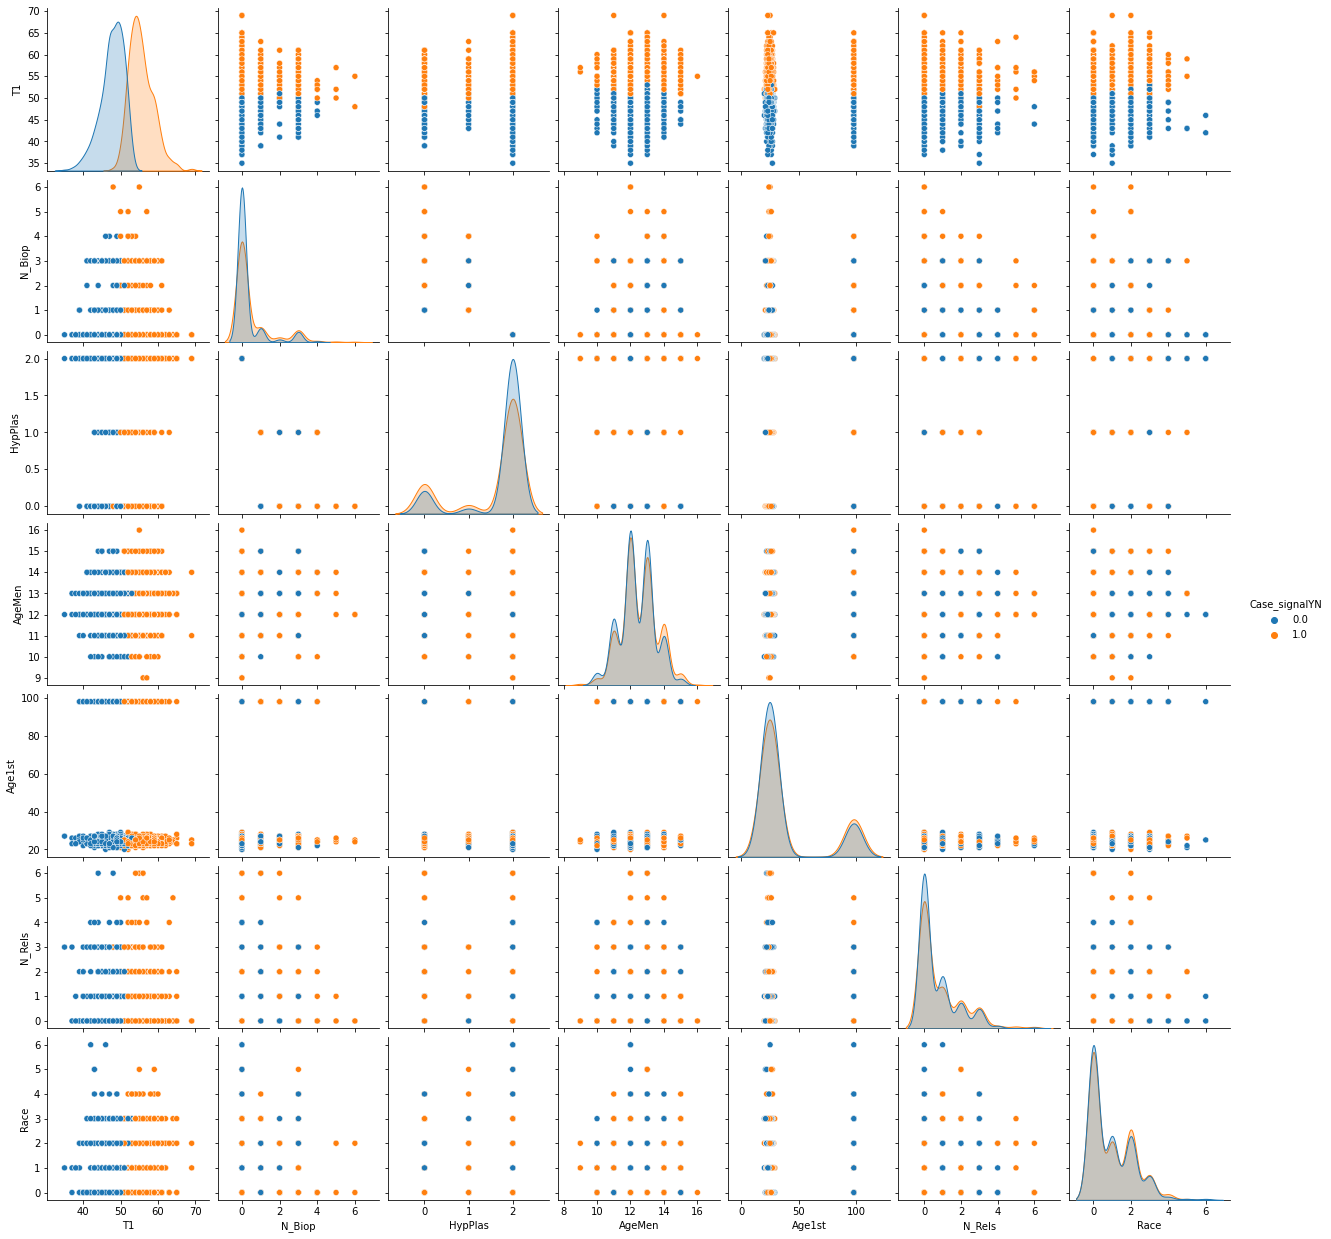

In [6]:
df = util.table_to_df(tab, x_only=False)
sns.pairplot(df, hue='Case_signalYN')
df.describe()

----
Are our data normally distributed?

Our continuous variables `T1` and `AgeMen` are not horribly far from normally distribution.

----

Are there any problematic values in any of our continuous variables?

Our remaining continuous variable, `Age1st`, uses the value `98` to indicate nulliparious (individual has not borne offspring).

`Age1st`'s standard deviation is being exaggerated to ~29 as a result of this encoding.

This could be problematic and there are a variety of ways to go about mitigating this issue; however, for simplicity, we will take no action at this time.

----
__Get `Race` distribution and cancer occurrence in population sample (Ming et al.)__

In [7]:
# get distribution of race
df_race_signal = pd.DataFrame()
df_race_signal['race'] = tab.X[:,-1].astype(int)
df_race_signal_counts = df_race_signal.value_counts().sort_index()
n_signal_race = df_race_signal_counts.values.sum()

# get occurrence of cancer by race
df_race_signal['cancer'] = tab.Y.astype(int)
p_cancer_by_race = df_race_signal.groupby('race').mean('cancer')

df_race_signal_prop = pd.DataFrame({'count_n': df_race_signal_counts,
                                    'count_p': df_race_signal_counts / n_signal_race,                                    
                                    'cancer': p_cancer_by_race.values.flatten()})
df_race_signal_prop

,count_n,count_p,cancer
race,,,
0,589,0.490833,0.490662
1,234,0.195000,0.478632
2,260,0.216667,0.526923
3,94,0.078333,0.510638
4,17,0.014167,0.647059
5,4,0.003333,0.500000
6,2,0.001667,0.000000


__Observation__:


The dataset above (Ming et al.) does not appear representative of many pathologies subject to Predictive Analytics in the Clinical Sciences.

The dataset above was intended to compare modern Machine Learning techniques to the traditional Gail model. 

Within the original context, the Breast Cancer prevalence of approximately 50% makes sense.

In the Clincial Sciences, a large number of pathologies subject to Predictive Analytics are much less prevalent.

----

__Mitigation__:


We will randomly remove 9/10 cancer cases; however, this may further diminish the quanitity of individuals belonging to minority races.

This will create class imbalance (10:1), which is more representative (relatively) of the prevalence of pathologies such as Breast Cancer.

----

__Note__:

We will later see that, in either case (balanced/imbalanced), the particular individuals in the less prevalent minority races happen to have risk-factor values that (when combined with the prevalence of cancer among members of the race) lead to high-confidence predictions.

Subsequently, we generate a larger population sample using the same procedure employed to create the original data (Ming et al.).

With a larger (ten-fold) sample size, we can more reasonably expect to have a viable representation of minority races, as well as being able to maintain this representation of minority races when randomly removing 9/10 cancer cases.

----
__Randomly remove 9/10 cancer cases__

In [8]:
# probability of getting breast cancer is not ~50-50

# get non-cancer
non_cancer_indices = np.array([x.row_index for x in tab if x.get_class().value == '0'])

# get cancer (randomized, but reproducible)
cancer_indices = np.array([x.row_index for x in tab if x.get_class().value == '1'])
cancer_indices_randomized = np.random.default_rng(42).permutation(cancer_indices)

# get 1 in 10 cancer
cancer_indices_tenth = cancer_indices_randomized[-int(len(cancer_indices) / 10):]

# create new table with cancer:non-cancer == 1/10:1
tab_dec = Orange.data.Table.from_table_rows(tab, 
                                            np.concatenate([cancer_indices_tenth, 
                                                            non_cancer_indices]))
tab.name = 'Ming et al. (1:1)'
tab_dec.name = 'Ming et al. (10:1)'
normalizer = Orange.preprocess.Normalizer(norm_type = Orange.preprocess.Normalize.NormalizeBySD)

----
__Visualize 1:1 vs 10:1 distributions (normalized)__

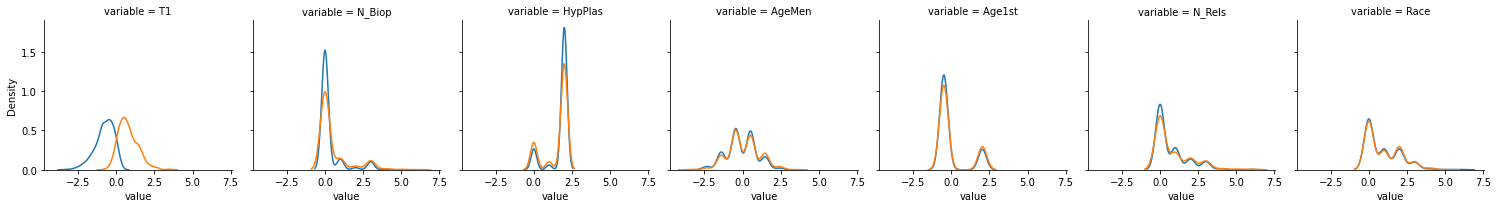

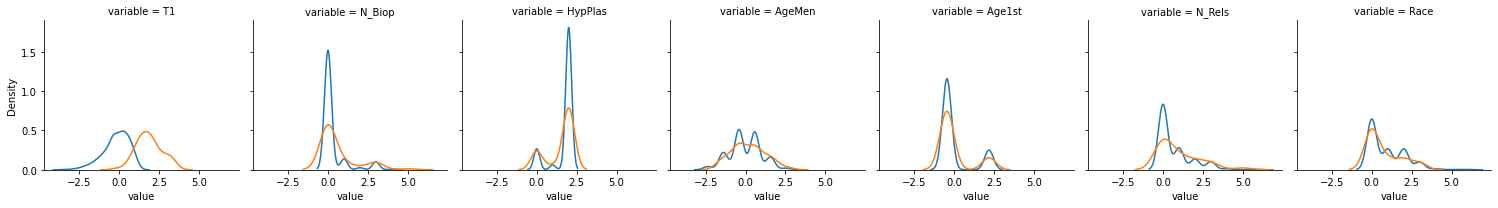

In [9]:
# 1:1 healthy:cancer
d = util.table_to_df(normalizer(tab), x_only=False)
d = pd.melt(d, d.columns[-1], d.columns[:-1])
g = sns.FacetGrid(d, col='variable', hue='Case_signalYN')
g.map(sns.kdeplot, 'value')
plt.show()

# 10:1 healthy:cancer
d = util.table_to_df(normalizer(tab_dec), x_only=False)
d = pd.melt(d, d.columns[-1], d.columns[:-1])
g = sns.FacetGrid(d, col='variable', hue='Case_signalYN')
g.map(sns.kdeplot, 'value')
plt.show()

__Observation:__

We can see that the 10:1 healthy:cancer data remains fairly representative of the 1:1 data.

----
__Get `Race` distribution and cancer occurrence in population sample (10:1 healthy:cancer)__

In [10]:
# get distribution of race
df_race_signal_dec = pd.DataFrame()
df_race_signal_dec['race'] = tab_dec.X[:,-1].astype(int)
df_race_signal_dec_counts = df_race_signal_dec.value_counts().sort_index()
n_signal_race = df_race_signal_dec_counts.values.sum()

# get occurrence of cancer by race
df_race_signal_dec['cancer'] = tab_dec.Y.astype(int)
p_cancer_by_race = df_race_signal_dec.groupby('race').mean('cancer')

df_race_signal_downsampl_prop = pd.DataFrame({'count_n': df_race_signal_dec_counts,
                                              'count_p': df_race_signal_dec_counts / n_signal_race,                                    
                                              'cancer': p_cancer_by_race.values.flatten()})

# add race count
df_race_signal_prop['count_n_dec'] = df_race_signal_dec_counts

# add race proportion
df_race_signal_prop['count_p_dec'] = df_race_signal_dec_counts / n_signal_race

# add race cancer prevalence
df_race_signal_prop['cancer_dec'] =  p_cancer_by_race.values.flatten()

# reorder
df_race_signal_prop = df_race_signal_prop.iloc[:,[0,3,2,5,1,4]]
df_race_signal_prop

,count_n,count_n_dec,cancer,cancer_dec,count_p,count_p_dec
race,,,,,,
0,589,335,0.490662,0.104478,0.490833,0.507576
1,234,131,0.478632,0.068702,0.195000,0.198485
2,260,132,0.526923,0.068182,0.216667,0.200000
3,94,52,0.510638,0.115385,0.078333,0.078788
4,17,6,0.647059,0.000000,0.014167,0.009091
5,4,2,0.500000,0.000000,0.003333,0.003030
6,2,2,0.000000,0.000000,0.001667,0.003030


__Note__:

The small number of individuals belonging to `race` 4/5/6, combined with the lack of any of these individuals having cancer (`cancer_dec`), may increase bias in the classifier and potentially overconfidence in some Conformal Predictions.

The population sample is not representative.

Individuals belonging to `race` 4/5/6 do not truly have a Breast Cancer risk of 0% (10:1 sample).

Prior to downsampling (1:1 sample), the data was already not representative for `race` 6.

----

## Get Cancer Correlation with Independent Variables (1:1 => 10:1)

In [11]:
df_tab = util.table_to_df(tab, x_only=False)
df_cancer_X_correlation_matrix_signal = pd.DataFrame(df_tab.corr().iloc[-1, :]).T
df_cancer_X_correlation_matrix_signal

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


In [12]:
df_tab_dec = util.table_to_df(tab_dec, x_only=False)
df_cancer_X_correlation_matrix_signal_dec = pd.DataFrame(df_tab_dec.corr().iloc[-1, :]).T
df_cancer_X_correlation_matrix_signal_dec

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.584841,0.106319,-0.088406,0.055188,-0.004393,0.081889,-0.040239,1.0


__Observation__:


Majority of the correlation coefficients retain their respective proportions and sign change only occurred on the two least correlated variables.

This is not to say that correlation coefficients, alone, quantify how similar/different two given samples are, but can be an early warning sign of potential issues.

As noted above, we see the lack of any individuals belonging to `race` 4/5/6 having cancer may be contributing to the correlation between `Race` and `Case_signalYN` (cancer) becoming slightly negative. 

This is a fairly reasonable result and we shall proceed.

Subsequently, we repeat the following experiments with a larger sample in order to substantiate/refute any findings that may be attributed to an unrepresentative sample.

----

__Experiment__:

We will utilize Logistic Regression as our underlying classifier.

We will pair this classifier with a general-purpose nonconformity measure (`InverseProbability`) $1 - p$, where $p$ is the probability assigned to the actual class by the underlying classifier.

This pairing will be used to construct an Inductive Conformal Predictor (`InductiveClassifier`).

An Inductive Conformal Predictor will be constructed for each dataset above (healthy:cancer - 1:1 and 10:1).

Each Inductive Conformal Predictor will be fit, calibrated, and used to make predictions.

We will then evaluate the relationship between the lowest `confidence`/`credibility` predictions, respectively, and `race`.

# Ming et al. Data 
----

(original n=1200; cancer-downsample n=660)

----

----

----

## Logistic Regression (split)
----

In this split experiment, we will:

- Split both sets of data (healthy:cancer = 1:1 & 10:1) into train/calibrate/test sets
- Normalize each split individually
- Explore the high variance among splits' cancer correlation coefficients
- Run a condensed form of the experiment
- Assess the results/issues
- Propose a way forward

----
### Splits data into train, calibrate, and test sets

----
1:1 healthy:cancer

In [13]:
np.random.seed(42) # reproducibility

train, test = next(cp.evaluation.RandomSampler(tab, 2, 1)) # 2:1 train:test
train, calibrate = next(cp.evaluation.RandomSampler(train,2,1)) # 2:1 train:calibrate

----
10:1 healthy:cancer

In [14]:
np.random.seed(42) # reproducibility

train_dec, test_dec = next(cp.evaluation.RandomSampler(tab_dec, 2, 1)) # 2:1 train:test
train_dec, calibrate_dec = next(cp.evaluation.RandomSampler(train_dec,2,1)) # 2:1 train:calibrate

----
### Normalize splits

Note: one should review data after splitting to validate the type of normalization used; however, substantial bias relating to aspects of categorical variables (e.g., `race`) that are not subject to normalization is already anticipated.

In [15]:
normalizer = Orange.preprocess.Normalizer(norm_type = Orange.preprocess.Normalize.NormalizeBySD)

train = normalizer(train)
calibrate = normalizer(calibrate)
test = normalizer(test)

train_dec = normalizer(train_dec)
calibrate = normalizer(calibrate_dec)
test_dec = normalizer(test_dec)

----
### Check cancer correlation coefficients among splits (1:1 healthy:cancer)

In [16]:
# train 1:1
pd.DataFrame(util.table_to_df(train, x_only=False).corr().Case_signalYN).T

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.782313,0.094094,-0.098833,0.061348,0.040824,0.029199,0.042755,1.0


In [17]:
# calibrate 1:1
pd.DataFrame(util.table_to_df(calibrate, x_only=False).corr().Case_signalYN).T

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.552471,0.145558,-0.170856,0.117198,0.041634,0.078212,-0.194677,1.0


In [18]:
# test 1:1
pd.DataFrame(util.table_to_df(test, x_only=False).corr().Case_signalYN).T

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.768433,0.169719,-0.136046,0.070738,0.033485,0.095501,-0.011524,1.0


#### Split Variance Issue

----

__Observation__:

We can see the impact that splitting the data has had on the cancer correlation coefficients is quite drastic, particularly when compared to the impact we observed in randomly removing 9/10 cancer cases.

We can clearly see that variance among the train/calibrate/test sets is quite high.

----
### Check cancer correlation coefficients among splits (10:1 healthy:cancer)

In [19]:
# train 10:1
pd.DataFrame(util.table_to_df(train_dec, x_only=False).corr().Case_signalYN).T

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.595656,0.003041,-0.013202,0.020844,-0.032689,0.072159,0.037647,1.0


In [20]:
# calibrate 10:1
pd.DataFrame(util.table_to_df(calibrate_dec, x_only=False).corr().Case_signalYN).T

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.552471,0.145558,-0.170856,0.117198,0.041634,0.078212,-0.194677,1.0


In [21]:
# test 10:1
pd.DataFrame(util.table_to_df(test_dec, x_only=False).corr().Case_signalYN).T

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.594393,0.217395,-0.141402,0.046391,0.005259,0.098323,-0.032214,1.0


__Observation__:

We again see similar results.

It is clear that variance among train/calibrate/test sets is quite high.

The exception being the correlation between `T1` and `Case_signalYN` (cancer).

This is not surprising. 

The distribution of `T1` for cancer vs healthy individuals is, arguably, the most visually dissimilar among the risk factors (visualized graphically above).

Train/calibrate/test represented above are after randomly removing 9/10 cancer cases.

----
### Run condensed experiment

In [22]:
np.random.seed(42)

# create learner
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

# run experiments
experiment_logistic_signal = util.run_experiments(cc, train, test, calibrate, eps=0.05, method='Baseline Split Data')
experiment_logistic_cancer_downsampl = util.run_experiments(cc, train_dec, test_dec, calibrate_dec, eps=0.05, method='Baseline Split Data')

# get LDR (low confidence predictions) for 1:1
df_pred = experiment_logistic_signal.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_ldr = df_pred.iloc[-ldr_idx:,:].copy()

# get LDR (low confidence predictions) for 10:1
df_pred = experiment_logistic_cancer_downsampl.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_cancer_downsampl_ldr = df_pred.iloc[-ldr_idx:,:].copy()

----
#### `Race` distribution in LDR

----

__Visualize representative-ness of 1:1 healthy:cancer dataset splits by class__

----

__Build table of 1:1 and 10:1 low confidence predictions and `Race` distribution__

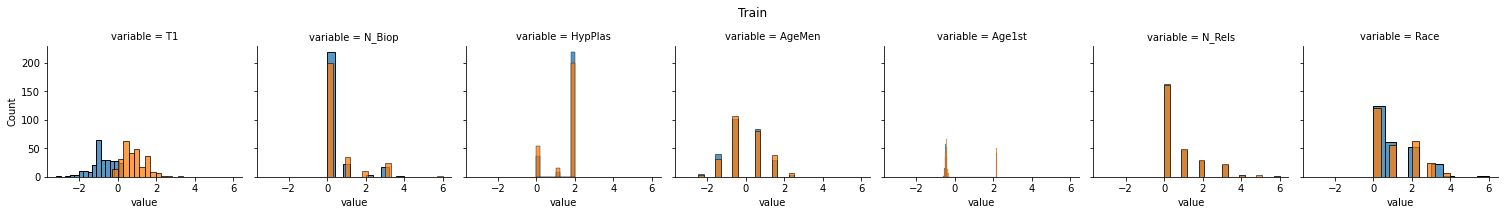

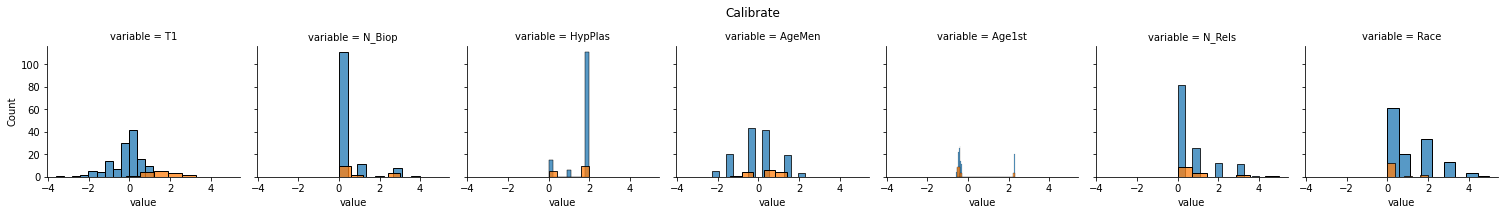

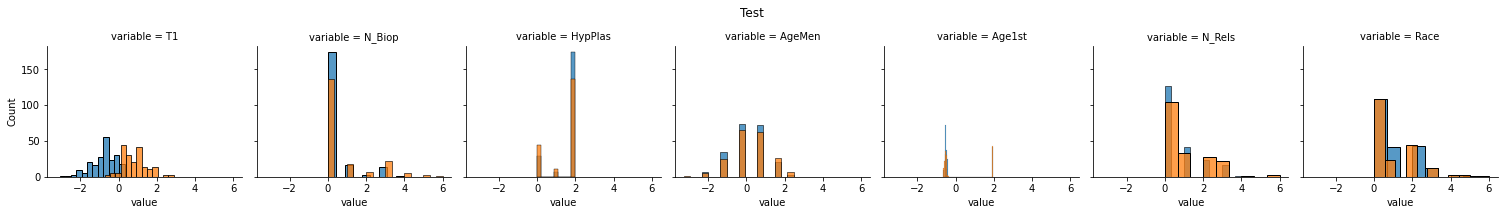

,count_n,count_n_dec,ldr_n_split,ldr_n_dec_split,cancer,cancer_dec,count_p,count_p_dec,ldr_p_split,ldr_p_dec_split
race,,,,,,,,,,
0,589,335,27,6,0.490662,0.104478,0.490833,0.507576,0.675,0.272727
1,234,131,0,8,0.478632,0.068702,0.195000,0.198485,0.000,0.363636
2,260,132,12,2,0.526923,0.068182,0.216667,0.200000,0.300,0.090909
3,94,52,0,6,0.510638,0.115385,0.078333,0.078788,0.000,0.272727
4,17,6,0,0,0.647059,0.000000,0.014167,0.009091,0.000,0.000000
5,4,2,1,0,0.500000,0.000000,0.003333,0.003030,0.025,0.000000
6,2,2,0,0,0.000000,0.000000,0.001667,0.003030,0.000,0.000000


In [23]:
# Experiment
# 1:1 healthy:cancer (split)
counts = df_pred_logistic_signal_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_split': counts / sums,
                            'ldr_n_split': counts})
table = df_race_signal_prop.join(proportions, 
                                 on='race', 
                                 how='left')
table = table.fillna(0)
table['ldr_n_split'] = table['ldr_n_split'].astype(int)
df_logistic_ldr_race_disparity = table.copy()
df_logistic_ldr_race_disparity = df_logistic_ldr_race_disparity.iloc[:, [0,1,7,2,3,4,5,6]]


# visualize how representative the 1:1 healthy:cancer data's train/test/calibration splits are
# train - 1:1
d = util.table_to_df(train, x_only=False)
d = pd.melt(d, d.columns[-1], d.columns[:-1])
g = sns.FacetGrid(d, col='variable', hue='Case_signalYN')
g.map(sns.histplot, 'value')
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Train')
plt.show()

# calibrate - 1:1
d = util.table_to_df(calibrate, x_only=False)
d = pd.melt(d, d.columns[-1], d.columns[:-1])
g = sns.FacetGrid(d, col='variable', hue='Case_signalYN')
g.map(sns.histplot, 'value')
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Calibrate')
plt.show()

# test - 1:1
d = util.table_to_df(test, x_only=False)
d = pd.melt(d, d.columns[-1], d.columns[:-1])
g = sns.FacetGrid(d, col='variable', hue='Case_signalYN')
g.map(sns.histplot, 'value')
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Test')
plt.show()

# Experiment
# 10:1 healthy:cancer (split)
counts = df_pred_logistic_signal_cancer_downsampl_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_dec_split': counts / sums, 
                            'ldr_n_dec_split': counts})
table = df_logistic_ldr_race_disparity.join(proportions, 
                                            on='race', 
                                            how='left')
table = table.fillna(0)
table['ldr_n_dec_split'] = table['ldr_n_dec_split'].astype(int)
df_logistic_table = table.copy()
df_logistic_table = df_logistic_table.iloc[:, [0,1,2,9,3,4,5,6,7,8]]
df_logistic_table

### __False Confidence__

----

__Observation__:

From the rows of graphs (train/calibrate/test, respectively) of the 1:1 (healthy:cancer) sample, we can clearly see partitions vary quite drastically--particularly in their representation of the class `cancer` (orange).

Based on the table of both samples/predictions, we see no apparent pattern between the 1:1 vs 10:1 experiments. The representation of `race` in the LDR tends to be either drastically low/high or not present at all.

In both experiments, the sparser minority races appear to be more likely to __not be represented at all__. The situation is worse than __low confidence__, it is __false confidence__.

A __small number of individuals__ belonging to a `race`, particularly in a situation where these indviduals do __not represent that population__, may be expected to result in either __low confidence__ or __false confidence__.

Partitioning the data not only __introduces bias__, but also tends to make unrepresentative data worse.

Additionally, partitioning data __makes it possibile__ for an __entire group__ (e.g., `race`) to be __excluded__ from the __test set__.

For example, if no individuals belonging to a given `race` are included in the test set, no predictions will be made for this `race`. 

Consequently, there are no low confidence predictions and the `race` is __not be represented at all__ in the LDR, predisposing one to the unfounded impression that confidence is not lacking in the predictions for a `race`.

----

__Two options__:

- Perform _repeated cross-validation_, such as _k-fold cross-validation_

- Use all individuals in the dataset for training, calibration, and testing

Because we are interested in the relationship between individual Conformal Predictions and the variables (particularly those not following a uniform distribution) upon which those predictions are made, we want to choose the option that provides the clearest view of this relationship.

A random partition of data is not necessarily balanced for all covariates. We could use stratification and attempt to create representative splits, but even with these techniques we are likely to miss latent feature space, etc.

We are not primarily interested in the suitability of a given learner for a particular problem domain or the mean accuracy of a predictive model on a set of data; however, if this were the case, _repeated cross-validation_ and _leave-one-out cross-validation_, respectively, may be more suitable candidates. [1]

1. Vanwinckelen, Gitte (2 October 2019). On Estimating Model Accuracy with Repeated Cross-Validation. lirias.kuleuven. pp. 39–44. ISBN 9789461970442.

----

__Mitigation__:

Due to the __bias__ incurred by splitting the data, the __high variance__ of results from different splits, and the possibility of __under-representation/exclusion__ of populations of interest, we will proceed by using all individuals in the dataset for training, calibration, and testing.

In doing so, we are able to more clearly focus on Conformal Prediction attributes (primarily `confidence`) and how they vary with respect to features (primarily `race`) of non-uniform distribution.

----
__Normalize datasets that will be used as a whole__

In [24]:
tab_signal = normalizer(tab)
tab_downsampl = normalizer(tab_dec)

----

----

----

----

----

## Logistic Regression (unsplit)
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,model,conformal_predictor,nonconformity
0,0.993566,0.506468,0.950833,0.0,0.97,0.920833,0.03,Ming et al. (1:1),False,logistic regression,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression)


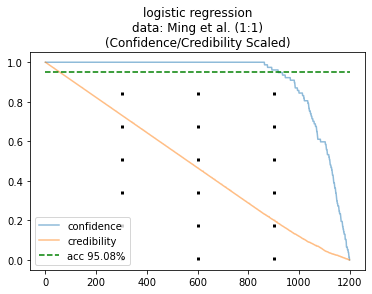

In [25]:
np.random.seed(42)


cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_signal = util.run_experiments(cc, 
                                                  tab_signal, 
                                                  tab_signal, 
                                                  tab_signal,
                                                  eps=0.05, 
                                                  method='Baseline Unsplit Data')

util.plot_experiments(experiment_logistic_signal)
experiment_logistic_signal.iloc[:,:-3]

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,model,conformal_predictor,nonconformity
0,0.997456,0.502686,0.951515,0.039394,0.960606,0.951515,0.0,Ming et al. (10:1),False,logistic regression,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression)


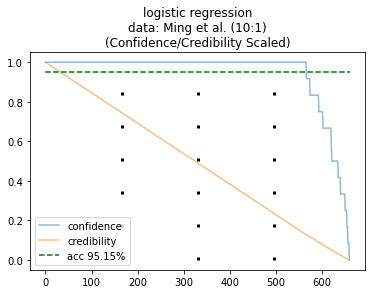

In [26]:
np.random.seed(42)


cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_cancer_downsampl = util.run_experiments(cc, 
                                                            tab_downsampl, 
                                                            tab_downsampl, 
                                                            tab_downsampl, 
                                                            eps=0.05, 
                                                            method='Baseline Unsplit Data')

util.plot_experiments(experiment_logistic_cancer_downsampl)
experiment_logistic_cancer_downsampl.iloc[:,:-3]

#### Observation:

In the cancer-downsample experiment, `confidence` continued to be sustained longer and fall more sharply, as expected, than the (1:1 healthy:cancer) Ming et al. dataset experiment.

----

---
__Lower Decile Range (LDR) Predictions - `confidence`/`credibility`__

In [27]:
df_pred = experiment_logistic_signal.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, 
                                            col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
1199,"[0, 1]",0.935054,0.064946,0.05,"[(0.0649458784346378, 0), (0.0649458784346378,...",True,0.0845,0,2,0.51721,-0.336957,0,1,1


In [28]:
df_pred = experiment_logistic_cancer_downsampl.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, 
                                                             col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_cancer_downsampl_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_cancer_downsampl_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
659,[],0.980333,0.019667,0.05,"[(0.019667170953101363, 0), (0.019667170953101...",False,1.445904,0,2,-1.38651,-0.55208,1,0,1


----
#### `Race` distribution in LDR

In [29]:
# 1:1 healthy:cancer (unsplit)
counts = df_pred_logistic_signal_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_unsplit': counts / sums,
                            'ldr_n_unsplit': counts})
table = df_logistic_table.join(proportions, 
                               on='race', 
                               how='left')
table = table.fillna(0)
table['ldr_n_unsplit'] = table['ldr_n_unsplit'].astype(int)
df_logistic_ldr_race_disparity_unsplit = table.copy()
df_logistic_table = df_logistic_ldr_race_disparity_unsplit.iloc[:, [0,1,2,3,11,4,5,6,7,8,9,10]]

# 10:1 healthy:cancer (unsplit)
counts = df_pred_logistic_signal_cancer_downsampl_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_dec_unsplit': counts / sums, 
                            'ldr_n_dec_unsplit': counts})
table = df_logistic_table.join(proportions, 
                               on='race', 
                               how='left')
table = table.fillna(0)
table['ldr_n_dec_unsplit'] = table['ldr_n_dec_unsplit'].astype(int)
df_logistic_signal_cancer_downsampl_ldr_race_disparity_unsplit = table.copy()
df_logistic_table = df_logistic_signal_cancer_downsampl_ldr_race_disparity_unsplit.iloc[:, [0,1,2,3,4,13,5,6,7,8,9,10,11,12]]
df_logistic_table

,count_n,count_n_dec,ldr_n_split,ldr_n_dec_split,ldr_n_unsplit,ldr_n_dec_unsplit,cancer,cancer_dec,count_p,count_p_dec,ldr_p_split,ldr_p_dec_split,ldr_p_unsplit,ldr_p_dec_unsplit
race,,,,,,,,,,,,,,
0,589,335,27,6,50,39,0.490662,0.104478,0.490833,0.507576,0.675,0.272727,0.416667,0.590909
1,234,131,0,8,33,13,0.478632,0.068702,0.195000,0.198485,0.000,0.363636,0.275000,0.196970
2,260,132,12,2,25,5,0.526923,0.068182,0.216667,0.200000,0.300,0.090909,0.208333,0.075758
3,94,52,0,6,12,8,0.510638,0.115385,0.078333,0.078788,0.000,0.272727,0.100000,0.121212
4,17,6,0,0,0,1,0.647059,0.000000,0.014167,0.009091,0.000,0.000000,0.000000,0.015152
5,4,2,1,0,0,0,0.500000,0.000000,0.003333,0.003030,0.025,0.000000,0.000000,0.000000
6,2,2,0,0,0,0,0.000000,0.000000,0.001667,0.003030,0.000,0.000000,0.000000,0.000000


In [30]:
df_logistic_table.loc[:, ['count_p', 'ldr_p_split', 'ldr_p_unsplit', 'count_p_dec', 'ldr_p_dec_split', 'ldr_p_dec_unsplit']]

,count_p,ldr_p_split,ldr_p_unsplit,count_p_dec,ldr_p_dec_split,ldr_p_dec_unsplit
race,,,,,,
0,0.490833,0.675,0.416667,0.507576,0.272727,0.590909
1,0.195000,0.000,0.275000,0.198485,0.363636,0.196970
2,0.216667,0.300,0.208333,0.200000,0.090909,0.075758
3,0.078333,0.000,0.100000,0.078788,0.272727,0.121212
4,0.014167,0.000,0.000000,0.009091,0.000000,0.015152
5,0.003333,0.025,0.000000,0.003030,0.000000,0.000000
6,0.001667,0.000,0.000000,0.003030,0.000000,0.000000


__Observation__:

We can see that we get results that appear less erratic than the partitioned data experiments, but still contain false confidence for the  sparsest 2-3 `race` groups.

The small quantity of individuals belonging to these races, in either case (balanced/imbalanced), in combination with the particular individuals' risk factor values and the prevalence of cancer in each race, appears to be leading to predictions that are not in the low confidence region.

The data not being representative for these minorities is leading to bias that is unlikely to generalize well in predictions for individuals of the respective populations.

__Mitigation__:

Subsequently, we generate a larger population sample using the same (Ming et al.) procedure.

Given a larger (ten-fold) sample, we can more reasonably expect to capture a viable representation of minority races, as well as being able to maintain this representation of minority races when randomly removing 9/10 cancer cases from the sample.

----

----

----

# Read in Data (10x sample size)

In [31]:
tab_10x = normalizer(Orange.data.Table('./data/signal_10x_with_header_for_orange.csv'))

----
__Get `Race` distribution and cancer occurrence in population sample__

In [32]:
# get distribution of race
df_race_signal_10x = pd.DataFrame()
df_race_signal_10x['race'] = tab_10x.X[:,-1].astype(int)
df_race_signal_10x_counts = df_race_signal_10x.value_counts().sort_index()
n_signal_race = df_race_signal_10x_counts.values.sum()

# get occurrence of cancer by race
df_race_signal_10x['cancer'] = tab_10x.Y.astype(int)
p_cancer_by_race = df_race_signal_10x.groupby('race').mean('cancer')

df_race_signal_10x_prop = pd.DataFrame({'count_n_10x': df_race_signal_10x_counts,
                                        'count_p_10x': df_race_signal_10x_counts / n_signal_race,                                    
                                        'cancer_10x': p_cancer_by_race.values.flatten()})
df_race_signal_10x_prop

,count_n_10x,count_p_10x,cancer_10x
race,,,
0,6043,0.503583,0.505378
1,2397,0.199750,0.487693
2,2366,0.197167,0.502959
3,935,0.077917,0.499465
4,126,0.010500,0.436508
5,68,0.005667,0.352941
6,65,0.005417,0.476923


----
__Randomly remove 9/10 cancer cases__

In [33]:
# probability of getting breast cancer is not ~50-50

# get non-cancer
non_cancer_indices = np.array([x.row_index for x in tab_10x if x.get_class().value == '0'])

# get cancer (randomized, but reproducible)
cancer_indices = np.array([x.row_index for x in tab_10x if x.get_class().value == '1'])
cancer_indices_randomized = np.random.default_rng(42).permutation(cancer_indices)

# get 1 in 10 cancer
cancer_indices_tenth = cancer_indices_randomized[-int(len(cancer_indices) / 10):]

# create new table with cancer:non-cancer == 1/10:1
tab_10x_downsampl = Orange.data.Table.from_table_rows(tab_10x, 
                                                      np.concatenate([cancer_indices_tenth, 
                                                                      non_cancer_indices]))

tab_10x.name = 'Ming et al. (10x)'
tab_10x_downsampl.name = 'Ming et al. (10x, cancer-downsample)'

----
__Get `Race` distribution and cancer occurrence in population sample (10:1 healthy:cancer)__

In [34]:
# get distribution of race
df_race_signal_10x_dec = pd.DataFrame()
df_race_signal_10x_dec['race'] = tab_10x_downsampl.X[:,-1].astype(int)
df_race_signal_10x_dec_counts = df_race_signal_10x_dec.value_counts().sort_index()
n_signal_race = df_race_signal_10x_dec_counts.values.sum()

# get occurrence of cancer by race
df_race_signal_10x_dec['cancer'] = tab_10x_downsampl.Y.astype(int)
p_cancer_by_race = df_race_signal_10x_dec.groupby('race').mean('cancer')

df_race_signal_10x_downsampl_prop = pd.DataFrame({'count_n_10x_dec': df_race_signal_10x_dec_counts,
                                                  'count_p_10x_dec': df_race_signal_10x_dec_counts / n_signal_race,                                    
                                                  'cancer_10x_dec': p_cancer_by_race.values.flatten()})
table = pd.concat([df_race_signal_10x_prop, df_race_signal_10x_downsampl_prop], axis=1)
table_10x = table.iloc[:, [0,3,2,5,1,4]]
table_10x

,count_n_10x,count_n_10x_dec,cancer_10x,cancer_10x_dec,count_p_10x,count_p_10x_dec
race,,,,,,
0,6043,3313,0.505378,0.097797,0.503583,0.501286
1,2397,1337,0.487693,0.081526,0.199750,0.202300
2,2366,1283,0.502959,0.083398,0.197167,0.194129
3,935,510,0.499465,0.082353,0.077917,0.077167
4,126,80,0.436508,0.112500,0.010500,0.012105
5,68,45,0.352941,0.022222,0.005667,0.006809
6,65,41,0.476923,0.170732,0.005417,0.006204


We can see that in the larger population sample has provided what appears to be a viable representation of all races in both the 1:1 and the downsampled 10:1 (healthy:cancer) data.

The most obvious difference being, there are no `race` populations in either sample that have a cancer prevalence of 0%.

----

## Get Cancer Correlation with Independent Variables

In [35]:
df_tab_10x = util.table_to_df(tab_10x, x_only=False)
df_cancer_X_correlation_matrix_signal_10x = pd.DataFrame(df_tab_10x.corr().iloc[-1, :]).T

df_tab_10x_downsampl = util.table_to_df(tab_10x_downsampl, x_only=False)
df_cancer_X_correlation_matrix_signal_10x_dec = pd.DataFrame(df_tab_10x_downsampl.corr().iloc[-1, :]).T

----

In [36]:
df_cancer_X_correlation_matrix_signal  # 1:1 - healthy:cancer (n=1200)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.773642,0.121657,-0.11216,0.061395,0.046615,0.063812,0.025359,1.0


In [37]:
df_cancer_X_correlation_matrix_signal_dec  # 10:1 - healthy:cancer (n=1200)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.584841,0.106319,-0.088406,0.055188,-0.004393,0.081889,-0.040239,1.0


In [38]:
df_cancer_X_correlation_matrix_signal_10x  # 1:1 healthy:cancer (n=12000)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.767549,0.081638,-0.073791,0.050976,-0.004405,0.061774,-0.014273,1.0


In [39]:
df_cancer_X_correlation_matrix_signal_10x_dec  # 10:1 healthy:cancer (n=12000)

,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,Case_signalYN
Case_signalYN,0.567539,0.047534,-0.033543,0.012155,0.001164,0.046679,-0.014438,1.0


The impact on correlation coefficients is consistent with the prior experiment.

The correlation coefficients, by and large, retain their respective proportions and sign change only occurrs for the single most weakly correlated variable.

This is a reasonable result.

As such, we shall proceed.

# Ming et al. Data (10x)
----

(original n=12000; cancer-downsample n=6609)

----

----

----

## Logistic Regression
----

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,model,conformal_predictor,nonconformity
0,0.991913,0.508163,0.950083,0.0,0.93375,0.883833,0.06625,Ming et al. (10x),False,logistic regression,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression)


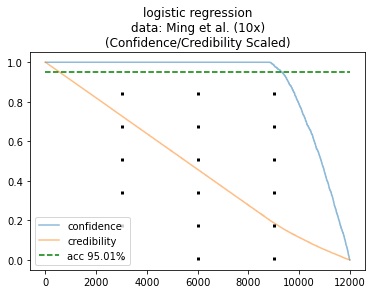

In [40]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_signal_10x = util.run_experiments(cc, 
                                                      tab_10x, 
                                                      tab_10x, 
                                                      tab_10x, 
                                                      eps=0.05, 
                                                      method='Baseline 10x Unsplit Data')

util.plot_experiments(experiment_logistic_signal_10x)
experiment_logistic_signal_10x.iloc[:,:-3]

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier,model,conformal_predictor,nonconformity
0,0.99814,0.502021,0.950219,0.036314,0.963686,0.950219,0.0,"Ming et al. (10x, cancer-downsample)",False,logistic regression,LogisticRegressionClassifier(skl_model=Logisti...,InductiveClassifier (InverseProbability (logis...,InverseProbability (logistic regression)


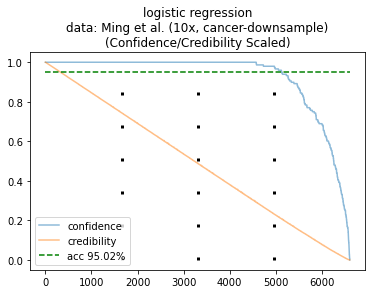

In [41]:
cc = cp.classification.InductiveClassifier(
        cp.nonconformity.InverseProbability(
            Orange.classification.LogisticRegressionLearner()))

experiment_logistic_10x_downsampl = util.run_experiments(cc, 
                                                         tab_10x_downsampl,                                            
                                                         tab_10x_downsampl, 
                                                         tab_10x_downsampl, 
                                                         eps=0.05, 
                                                         method='Baseline 10x Unsplit Data')

util.plot_experiments(experiment_logistic_10x_downsampl)
experiment_logistic_10x_downsampl.iloc[:,:-3]

---
__Get Lower Decile Range (LDR) Predictions - `confidence`/`credibility`__

----

In [42]:
df_pred = experiment_logistic_signal_10x.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_signal_10x_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_signal_10x_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
11999,"[0, 1]",0.92209,0.07791,0.05,"[(0.07791017415215398, 0), (0.0779101741521539...",True,-0.293725,2,0,2.407616,-0.416625,0,0,0


In [43]:
df_pred = experiment_logistic_10x_downsampl.loc[0, 'df']
df_pred = util.sort_reindex(df_pred, col=['confidence','credibility'])
ldr_idx = int(len(df_pred.index.values) / 10)
df_pred_logistic_10x_downsampl_ldr = df_pred.iloc[-ldr_idx:,:].copy()
df_pred_logistic_10x_downsampl_ldr.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
6608,[],0.977458,0.022542,0.05,"[(0.02254160363086233, 0), (0.0225416036308623...",False,0.301329,0,2,1.442897,-0.416625,0,0,1


----
#### `Race` distribution in LDR

In [44]:
# 1:1 healthy:cancer
counts = df_pred_logistic_signal_10x_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_10x_unsplit': counts / sums,
                            'ldr_n_10x_unsplit': counts})
table = table_10x.join(proportions, 
                       on='race', 
                       how='left')
table = table.fillna(0)
table['ldr_n_10x_unsplit'] = table['ldr_n_10x_unsplit'].astype(int)
df_logistic_ldr_race_disparity_10x = table.copy()
df_logistic_table_10x = df_logistic_ldr_race_disparity_10x.iloc[:, [0,1,7,2,3,4,5,6]]

# 10:1 healthy:cancer
counts = df_pred_logistic_10x_downsampl_ldr.Race.value_counts().sort_index()
sums = counts.values.sum()
proportions = pd.DataFrame({'ldr_p_10x_unsplit_dec': counts / sums,
                            'ldr_n_10x_unsplit_dec': counts})
table = df_logistic_table_10x.join(proportions, 
                                   on='race', 
                                   how='left')
table = table.fillna(0)
table['ldr_n_10x_unsplit_dec'] = table['ldr_n_10x_unsplit_dec'].astype(int)
df_logistic_ldr_race_disparity_10x_downsampl = table.copy()
df_logistic_table_10x = df_logistic_ldr_race_disparity_10x_downsampl.iloc[:, [0,1,2,9,3,4,5,6,7,8]]
df_logistic_table_10x

,count_n_10x,count_n_10x_dec,ldr_n_10x_unsplit,ldr_n_10x_unsplit_dec,cancer_10x,cancer_10x_dec,count_p_10x,count_p_10x_dec,ldr_p_10x_unsplit,ldr_p_10x_unsplit_dec
race,,,,,,,,,,
0,6043,3313,587,353,0.505378,0.097797,0.503583,0.501286,0.489167,0.534848
1,2397,1337,249,121,0.487693,0.081526,0.199750,0.202300,0.207500,0.183333
2,2366,1283,246,107,0.502959,0.083398,0.197167,0.194129,0.205000,0.162121
3,935,510,85,54,0.499465,0.082353,0.077917,0.077167,0.070833,0.081818
4,126,80,17,13,0.436508,0.112500,0.010500,0.012105,0.014167,0.019697
5,68,45,7,3,0.352941,0.022222,0.005667,0.006809,0.005833,0.004545
6,65,41,9,9,0.476923,0.170732,0.005417,0.006204,0.007500,0.013636


---- 
### `n=1200`

----

__1:1__ race proportion sample vs low-confidence --- __10:1__ race proportion sample vs low-confidence

In [45]:
df_logistic_table.loc[:, 'cancer':].iloc[:, [2,6,3,7]]

,count_p,ldr_p_unsplit,count_p_dec,ldr_p_dec_unsplit
race,,,,
0,0.490833,0.416667,0.507576,0.590909
1,0.195000,0.275000,0.198485,0.196970
2,0.216667,0.208333,0.200000,0.075758
3,0.078333,0.100000,0.078788,0.121212
4,0.014167,0.000000,0.009091,0.015152
5,0.003333,0.000000,0.003030,0.000000
6,0.001667,0.000000,0.003030,0.000000


---- 
### `n=12000`

----

__1:1__ race proportion sample vs low-confidence --- __10:1__ race proportion sample vs low-confidence

In [46]:
df_logistic_table_10x.loc[:, 'cancer_10x':].iloc[:, [2,4,3,5]]

,count_p_10x,ldr_p_10x_unsplit,count_p_10x_dec,ldr_p_10x_unsplit_dec
race,,,,
0,0.503583,0.489167,0.501286,0.534848
1,0.199750,0.207500,0.202300,0.183333
2,0.197167,0.205000,0.194129,0.162121
3,0.077917,0.070833,0.077167,0.081818
4,0.010500,0.014167,0.012105,0.019697
5,0.005667,0.005833,0.006809,0.004545
6,0.005417,0.007500,0.006204,0.013636


----

----
__Plot population sample race distribution vs low confidence prediction race distribution__

We can see that with the data in our original sample of size of 1,200 (Ming et al.) we did not encounter a set of predictions where at least one instance of each race was present in the LDR (low confidence region).

Subsequently, we generated a sample of size 12,000--using the same procedure (Ming et al.)--and performed the (unsplit) 1:1 and 10:1 (healthy:cancer) experiments with this data.

### Results `n=1200`

In [516]:
df_logistic_table

,count_n,count_n_dec,ldr_n_split,ldr_n_dec_split,ldr_n_unsplit,ldr_n_dec_unsplit,cancer,cancer_dec,count_p,count_p_dec,ldr_p_split,ldr_p_dec_split,ldr_p_unsplit,ldr_p_dec_unsplit
race,,,,,,,,,,,,,,
0,589,335,27,6,50,39,0.490662,0.104478,0.490833,0.507576,0.675,0.272727,0.416667,0.590909
1,234,131,0,8,33,13,0.478632,0.068702,0.195000,0.198485,0.000,0.363636,0.275000,0.196970
2,260,132,12,2,25,5,0.526923,0.068182,0.216667,0.200000,0.300,0.090909,0.208333,0.075758
3,94,52,0,6,12,8,0.510638,0.115385,0.078333,0.078788,0.000,0.272727,0.100000,0.121212
4,17,6,0,0,0,1,0.647059,0.000000,0.014167,0.009091,0.000,0.000000,0.000000,0.015152
5,4,2,1,0,0,0,0.500000,0.000000,0.003333,0.003030,0.025,0.000000,0.000000,0.000000
6,2,2,0,0,0,0,0.000000,0.000000,0.001667,0.003030,0.000,0.000000,0.000000,0.000000


,count_n,count_n_dec,ldr_n_split,ldr_n_dec_split,ldr_n_unsplit,ldr_n_dec_unsplit,cancer,cancer_dec,count_p,count_p_dec,ldr_p_split,ldr_p_dec_split,ldr_p_unsplit,ldr_p_dec_unsplit
race,,,,,,,,,,,,,,
0,589,335,27,6,50,39,0.490662,0.104478,0.490833,0.507576,0.675,0.272727,0.416667,0.590909
1,234,131,0,8,33,13,0.478632,0.068702,0.195000,0.198485,0.000,0.363636,0.275000,0.196970
2,260,132,12,2,25,5,0.526923,0.068182,0.216667,0.200000,0.300,0.090909,0.208333,0.075758
3,94,52,0,6,12,8,0.510638,0.115385,0.078333,0.078788,0.000,0.272727,0.100000,0.121212
4,17,6,0,0,0,1,0.647059,0.000000,0.014167,0.009091,0.000,0.000000,0.000000,0.015152
5,4,2,1,0,0,0,0.500000,0.000000,0.003333,0.003030,0.025,0.000000,0.000000,0.000000
6,2,2,0,0,0,0,0.000000,0.000000,0.001667,0.003030,0.000,0.000000,0.000000,0.000000


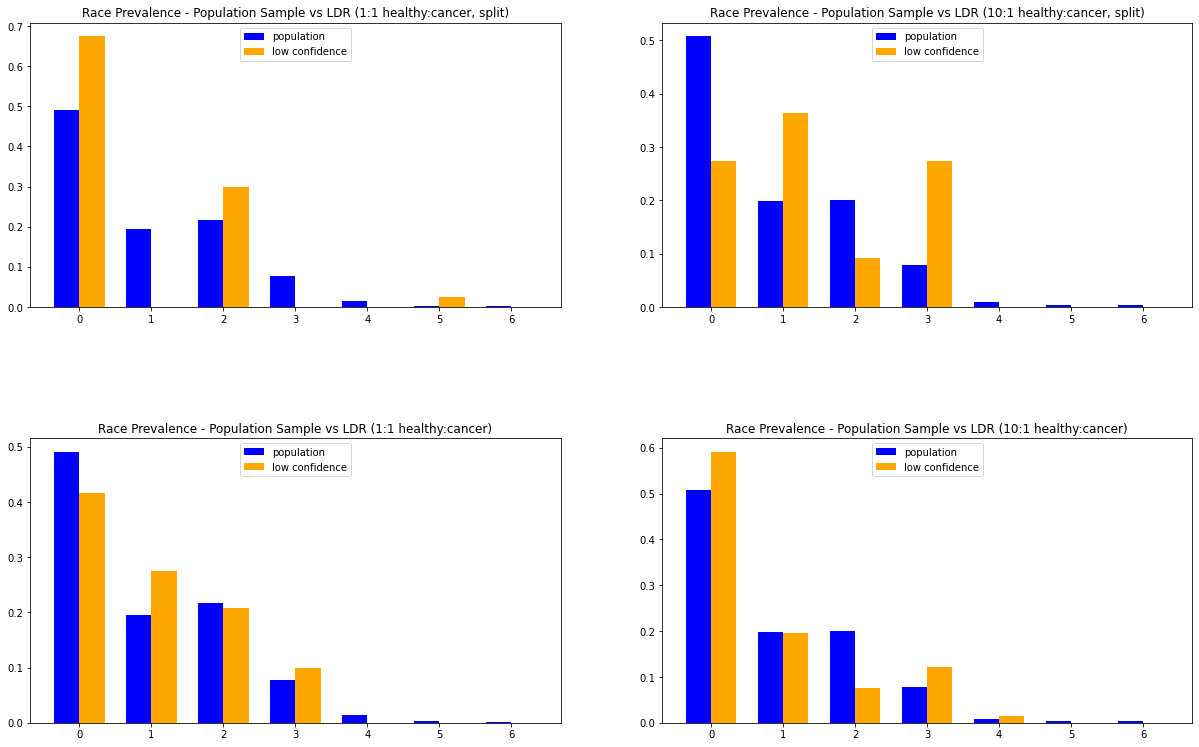

In [520]:
fig, axs = plt.subplots(2, 2)

ax = axs[0,0]
x = np.arange(len(df_logistic_table.index))
width = 0.35
pop_race = df_logistic_table.count_p
lcr_race = df_logistic_table.ldr_p_split
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (1:1 healthy:cancer, split)')

ax = axs[0,1]
x = np.arange(len(df_logistic_table.index))
width = 0.35
pop_race = df_logistic_table.count_p_dec
lcr_race = df_logistic_table.ldr_p_dec_split
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (10:1 healthy:cancer, split)')

ax = axs[1,0]
x = np.arange(len(df_logistic_table.index))
width = 0.35
pop_race = df_logistic_table.count_p
lcr_race = df_logistic_table.ldr_p_unsplit
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (1:1 healthy:cancer)')

ax = axs[1,1]
x = np.arange(len(df_logistic_table.index))
width = 0.35
pop_race = df_logistic_table.count_p_dec
lcr_race = df_logistic_table.ldr_p_dec_unsplit
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
fig.tight_layout()
ax.set_title('Race Prevalence - Population Sample vs LDR (10:1 healthy:cancer)')

fig.set_figwidth(18)
fig.set_figheight(12)
df_logistic_table

We can see from the upper graphs that the results of the split experiments appear a more erratic than the lower, unsplit counterparts.

In the 1:1 split/unsplit experiments, the three least prevelant races total 23 individuals (of 1200). 

In the 10:1 split/unsplit experiments, these three races total 10 individuals.

In both experiments, one or more of these three races have 0 individuals with cancer in the sample.

It is likely the unrepresentative sample caused bias in both experiments.

The variance introduced by partitioning the data compounded this problem in the split experiment.

----

For these reasons, we __remove the bias introduced by splitting the data__ and additionally utilize a sample we can more reasonably expect to provide a __viable representation of the variance in the minority `race` populations__.

----

__This is the _modus operandi_ of the experiments for which we present the results below__

----

### Results `n=12000`

,count_n_10x,count_n_10x_dec,ldr_n_10x_unsplit,ldr_n_10x_unsplit_dec,cancer_10x,cancer_10x_dec,count_p_10x,count_p_10x_dec,ldr_p_10x_unsplit,ldr_p_10x_unsplit_dec
race,,,,,,,,,,
0,6043,3313,587,353,0.505378,0.097797,0.503583,0.501286,0.489167,0.534848
1,2397,1337,249,121,0.487693,0.081526,0.199750,0.202300,0.207500,0.183333
2,2366,1283,246,107,0.502959,0.083398,0.197167,0.194129,0.205000,0.162121
3,935,510,85,54,0.499465,0.082353,0.077917,0.077167,0.070833,0.081818
4,126,80,17,13,0.436508,0.112500,0.010500,0.012105,0.014167,0.019697
5,68,45,7,3,0.352941,0.022222,0.005667,0.006809,0.005833,0.004545
6,65,41,9,9,0.476923,0.170732,0.005417,0.006204,0.007500,0.013636


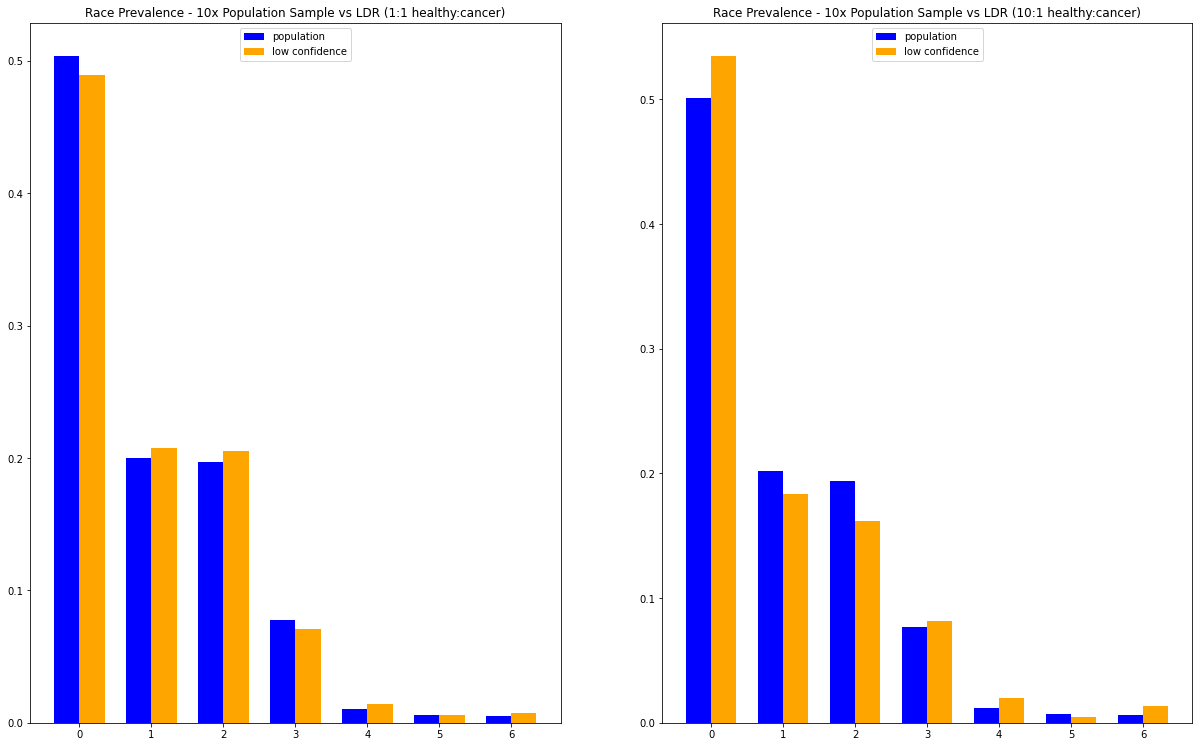

In [513]:
fig, axs = plt.subplots(1, 2)

ax = axs[0]
x = np.arange(len(df_logistic_table_10x.index))
width = 0.35
pop_race = df_logistic_table_10x.count_p_10x
lcr_race = df_logistic_table_10x.ldr_p_10x_unsplit
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
fig.tight_layout()
ax.set_title('Race Prevalence - 10x Population Sample vs LDR (1:1 healthy:cancer)')

ax = axs[1]
x = np.arange(len(df_logistic_table_10x.index))
width = 0.35
pop_race = df_logistic_table_10x.count_p_10x_dec
lcr_race = df_logistic_table_10x.ldr_p_10x_unsplit_dec
ax.bar(x - width/2, pop_race, width, color='blue', label='population')
ax.bar(x + width/2, lcr_race, width, color='orange', label='low confidence')
ax.legend(loc='upper center')
fig.tight_layout()
ax.set_title('Race Prevalence - 10x Population Sample vs LDR (10:1 healthy:cancer)')

fig.set_figwidth(18)
fig.set_figheight(12)

df_logistic_table_10x

We can see that with the data in our sample of size 12,000 (Ming et al.) we encounter at least one instance of each race in the LDR (low confidence region) for both (1:1 & 10:1) experiments.

Additionally, we observe that in both experiments:
- __Minority__ `race` 4, 5, and 6 (each representing __< 1.25%__ of the sample)
    - Tend to be __over-represented__ in the __low confidence region__ of both experiments' predictions
        - The exception is `race` 5 in the 10:1 experiment (0.58% vs 0.45%)
            - However, the small quantity of individuals belonging to this race (n=68) and the prevalence of cancer in individuals belonging to this race (1/68) may help account for the observed lack of low confidence predictions

----

----

----

----

----

## Contents

----

__Visualization of results from `LogisticRegression`, `RandomForest`, `KNeighborsClassifier`, and `AdaBoostClassifier` experiments using the Nonconformity Measure `InverseProbability`.__

__Distance-based `KNNFraction` Nonconformity Measure was applied to the the same experiment setups as a reference point.__

`KNNFraction` uses `Euclidean`, similar to `KNeighborsClassifier`, and is not applied to the underlying classifiers above.

----

In [60]:
# 'vigilant-computing-machine/source/experiment.py'
import source.experiment as exp

----

## Experiments:
- `n=1200`
    - __Mondrian__ = __False__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
    - __Mondrian__ = __True__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
- `n=12000`
    - __Mondrian__ = __False__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
    - __Mondrian__ = __True__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer

----

----

----

### `n=1200` Experiments

----

__Read in and Plot Experiment Results__


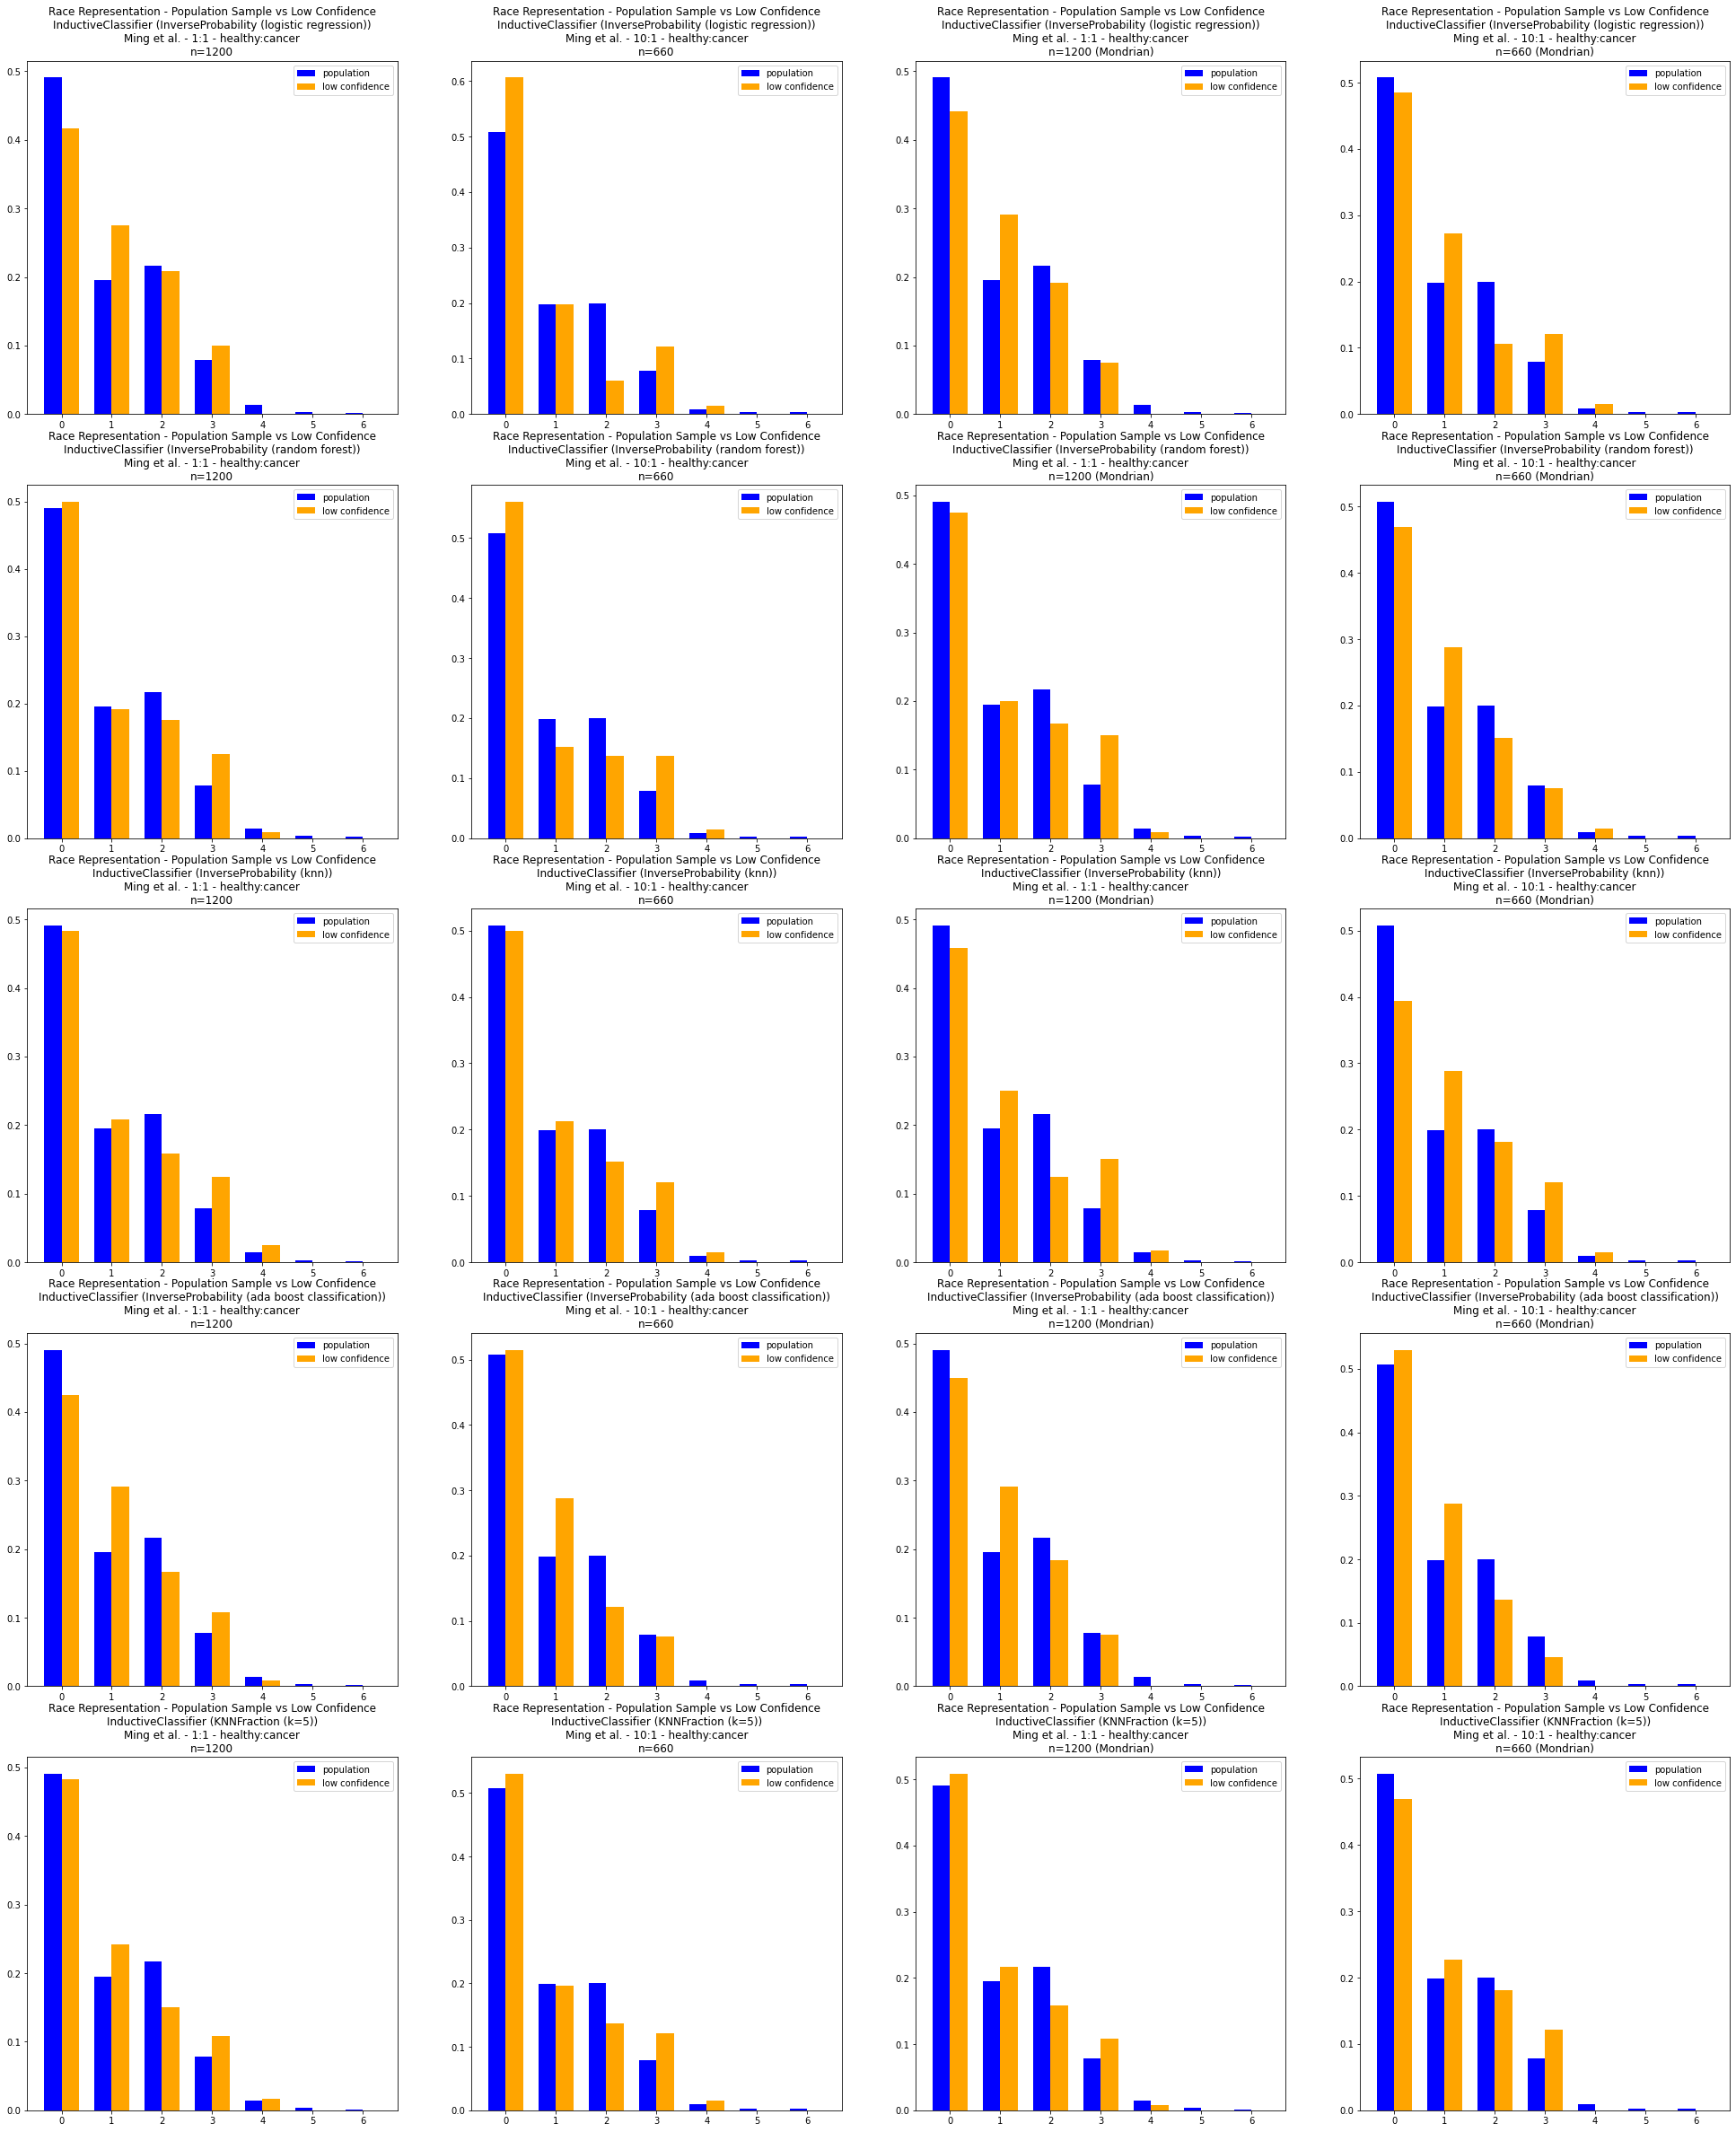

In [61]:
experiments = [util.read_experiment('./results/logistic_regression_1200_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_1200_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_1200_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_1200_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_1200_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_1200_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_1200_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_1200_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_1200_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_1200_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_1200_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_1200_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_1200_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_1200_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_imbalanced_mondrian_experiment.csv')]


col = 4
row = 5

fig, axs = plt.subplots(row, col)
fig.set_figheight(42)
fig.set_figwidth(34)

for i in range(row * col):
    row_idx = i // col
    col_idx = i % col
    util.plot_race_representation_from_experiment(experiments[i], ax=axs[row_idx, col_idx])

#### Observation:

Bear in mind that these are the results of experiments utilizing the population sample previously determined as likely to insufficiently represent the most sparsely populated `race` groups.

We can see that in the presense of `race` 4 individuals' predictions in the low confidence region varies among the experiments.

If investigation of `race` 4 indvidiuals indicates that confidence should be low for their predictions, then KNN appears to have been the most well suited underlying classifier to correctly identify this particular situation.

If the opposite is true, then across underlying classifiers, Mondrian Inductive Conformal Predictors more often picked up on this situation than their Inductive Conformal Predictor counterparts.

----

Note: the full set of predictions are available in each experiments' `'df'` column (e.g., `experiments[0].loc[0, 'df']`)

In [62]:
pd.concat(experiments).loc[:, 'confidence':'classifier']

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier
0,0.993566,0.506468,0.900833,0.069167,0.930833,0.900833,0.000000,Ming et al. - 1:1 - healthy:cancer,False,logistic regression
0,0.997456,0.502686,0.901515,0.093939,0.906061,0.901515,0.000000,Ming et al. - 10:1 - healthy:cancer,False,logistic regression
0,0.992670,0.507476,0.901667,0.066667,0.933333,0.901667,0.000000,Ming et al. - 1:1 - healthy:cancer,True,logistic regression
0,0.982278,0.507575,0.903030,0.063636,0.936364,0.903030,0.000000,Ming et al. - 10:1 - healthy:cancer,True,logistic regression
0,0.998612,0.824756,0.900833,0.099167,0.900833,0.900833,0.000000,Ming et al. - 1:1 - healthy:cancer,False,random forest
0,0.998446,0.884665,0.954545,0.045455,0.954545,0.954545,0.000000,Ming et al. - 10:1 - healthy:cancer,False,random forest
0,0.997761,0.824989,0.917500,0.082500,0.917500,0.917500,0.000000,Ming et al. - 1:1 - healthy:cancer,True,random forest
0,0.984962,0.911020,0.933333,0.066667,0.933333,0.933333,0.000000,Ming et al. - 10:1 - healthy:cancer,True,random forest
0,0.983689,0.734906,0.924167,0.000000,1.000000,0.924167,0.000000,Ming et al. - 1:1 - healthy:cancer,False,knn
0,0.995936,0.894487,0.940909,0.045455,0.954545,0.940909,0.000000,Ming et al. - 10:1 - healthy:cancer,False,knn


----

----

### `n=12000` Experiments

----

__Read in and Plot Experiment Results__


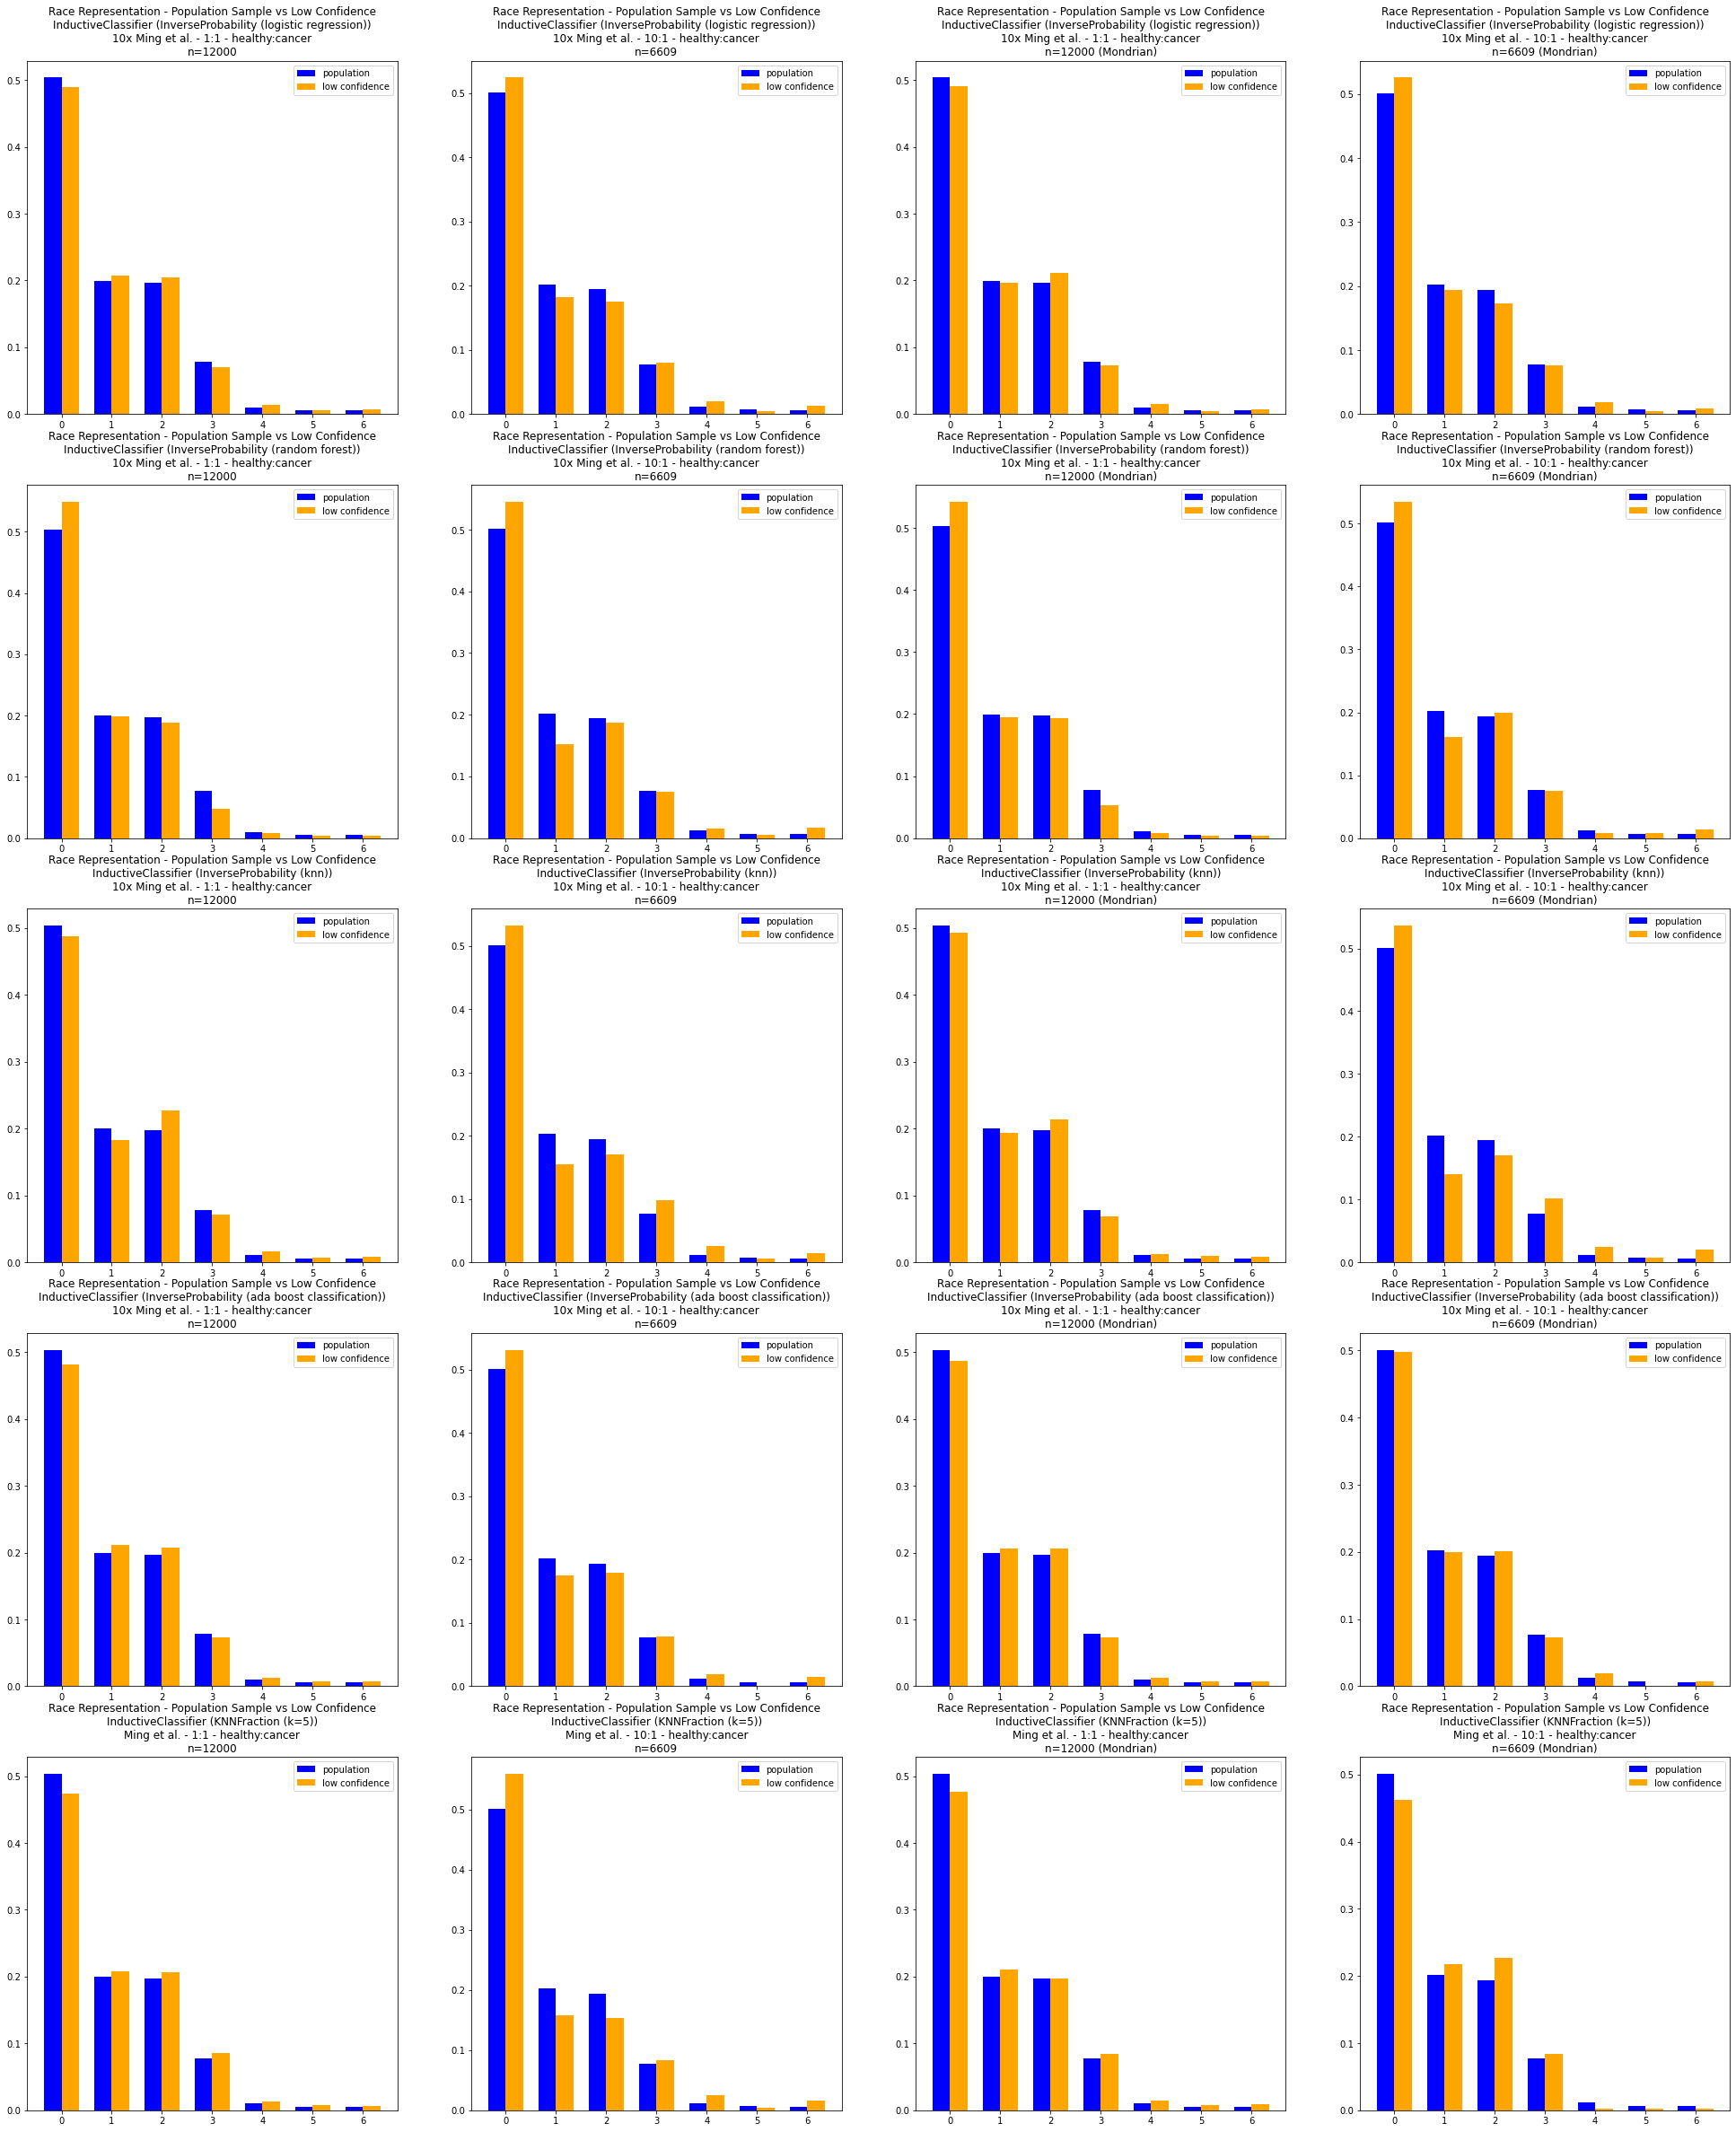

In [63]:
experiments = [util.read_experiment('./results/logistic_regression_12000_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_12000_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_12000_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_12000_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_12000_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_12000_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_12000_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_12000_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_12000_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_12000_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_12000_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_12000_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_12000_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_12000_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_imbalanced_mondrian_experiment.csv')]


col = 4
row = 5

fig, axs = plt.subplots(row, col)
fig.set_figheight(42)
fig.set_figwidth(34)

for i in range(row * col):
    row_idx = i // col
    col_idx = i % col
    util.plot_race_representation_from_experiment(experiments[i], ax=axs[row_idx, col_idx])    

In [64]:
pd.concat(experiments).loc[:, 'confidence':'classifier']

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier
0,0.991913,0.508163,0.900083,0.039500,0.960500,0.900083,0.000000,10x Ming et al. - 1:1 - healthy:cancer,False,logistic regression
0,0.998153,0.502008,0.901195,0.091844,0.908156,0.901195,0.000000,10x Ming et al. - 10:1 - healthy:cancer,False,logistic regression
0,0.991823,0.508341,0.900333,0.038500,0.961500,0.900333,0.000000,10x Ming et al. - 1:1 - healthy:cancer,True,logistic regression
0,0.990868,0.507395,0.900741,0.050235,0.949765,0.900741,0.000000,10x Ming et al. - 10:1 - healthy:cancer,True,logistic regression
0,0.997174,0.803856,0.908250,0.078750,0.921250,0.908250,0.000000,10x Ming et al. - 1:1 - healthy:cancer,False,random forest
0,0.999604,0.910560,0.905281,0.094719,0.905281,0.905281,0.000000,10x Ming et al. - 10:1 - healthy:cancer,False,random forest
0,0.997082,0.803915,0.901750,0.085750,0.914250,0.901750,0.000000,10x Ming et al. - 1:1 - healthy:cancer,True,random forest
0,0.997808,0.915207,0.929339,0.069148,0.930852,0.929339,0.000000,10x Ming et al. - 10:1 - healthy:cancer,True,random forest
0,0.986283,0.789914,0.929417,0.000000,1.000000,0.929417,0.000000,10x Ming et al. - 1:1 - healthy:cancer,False,knn
0,0.997482,0.885931,0.942805,0.044939,0.955061,0.942805,0.000000,10x Ming et al. - 10:1 - healthy:cancer,False,knn


----

## Experiments:
- `n=1200` Race-Relative Risk (RRR)
    - __Mondrian__ = __False__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
    - __Mondrian__ = __True__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
- `n=12000` Race-Relative Risk (RRR)
    - __Mondrian__ = __False__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
    - __Mondrian__ = __True__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer

----

----

----

### `n=1200` Experiments (RRR)

----

__Read in and Plot Experiment Results__


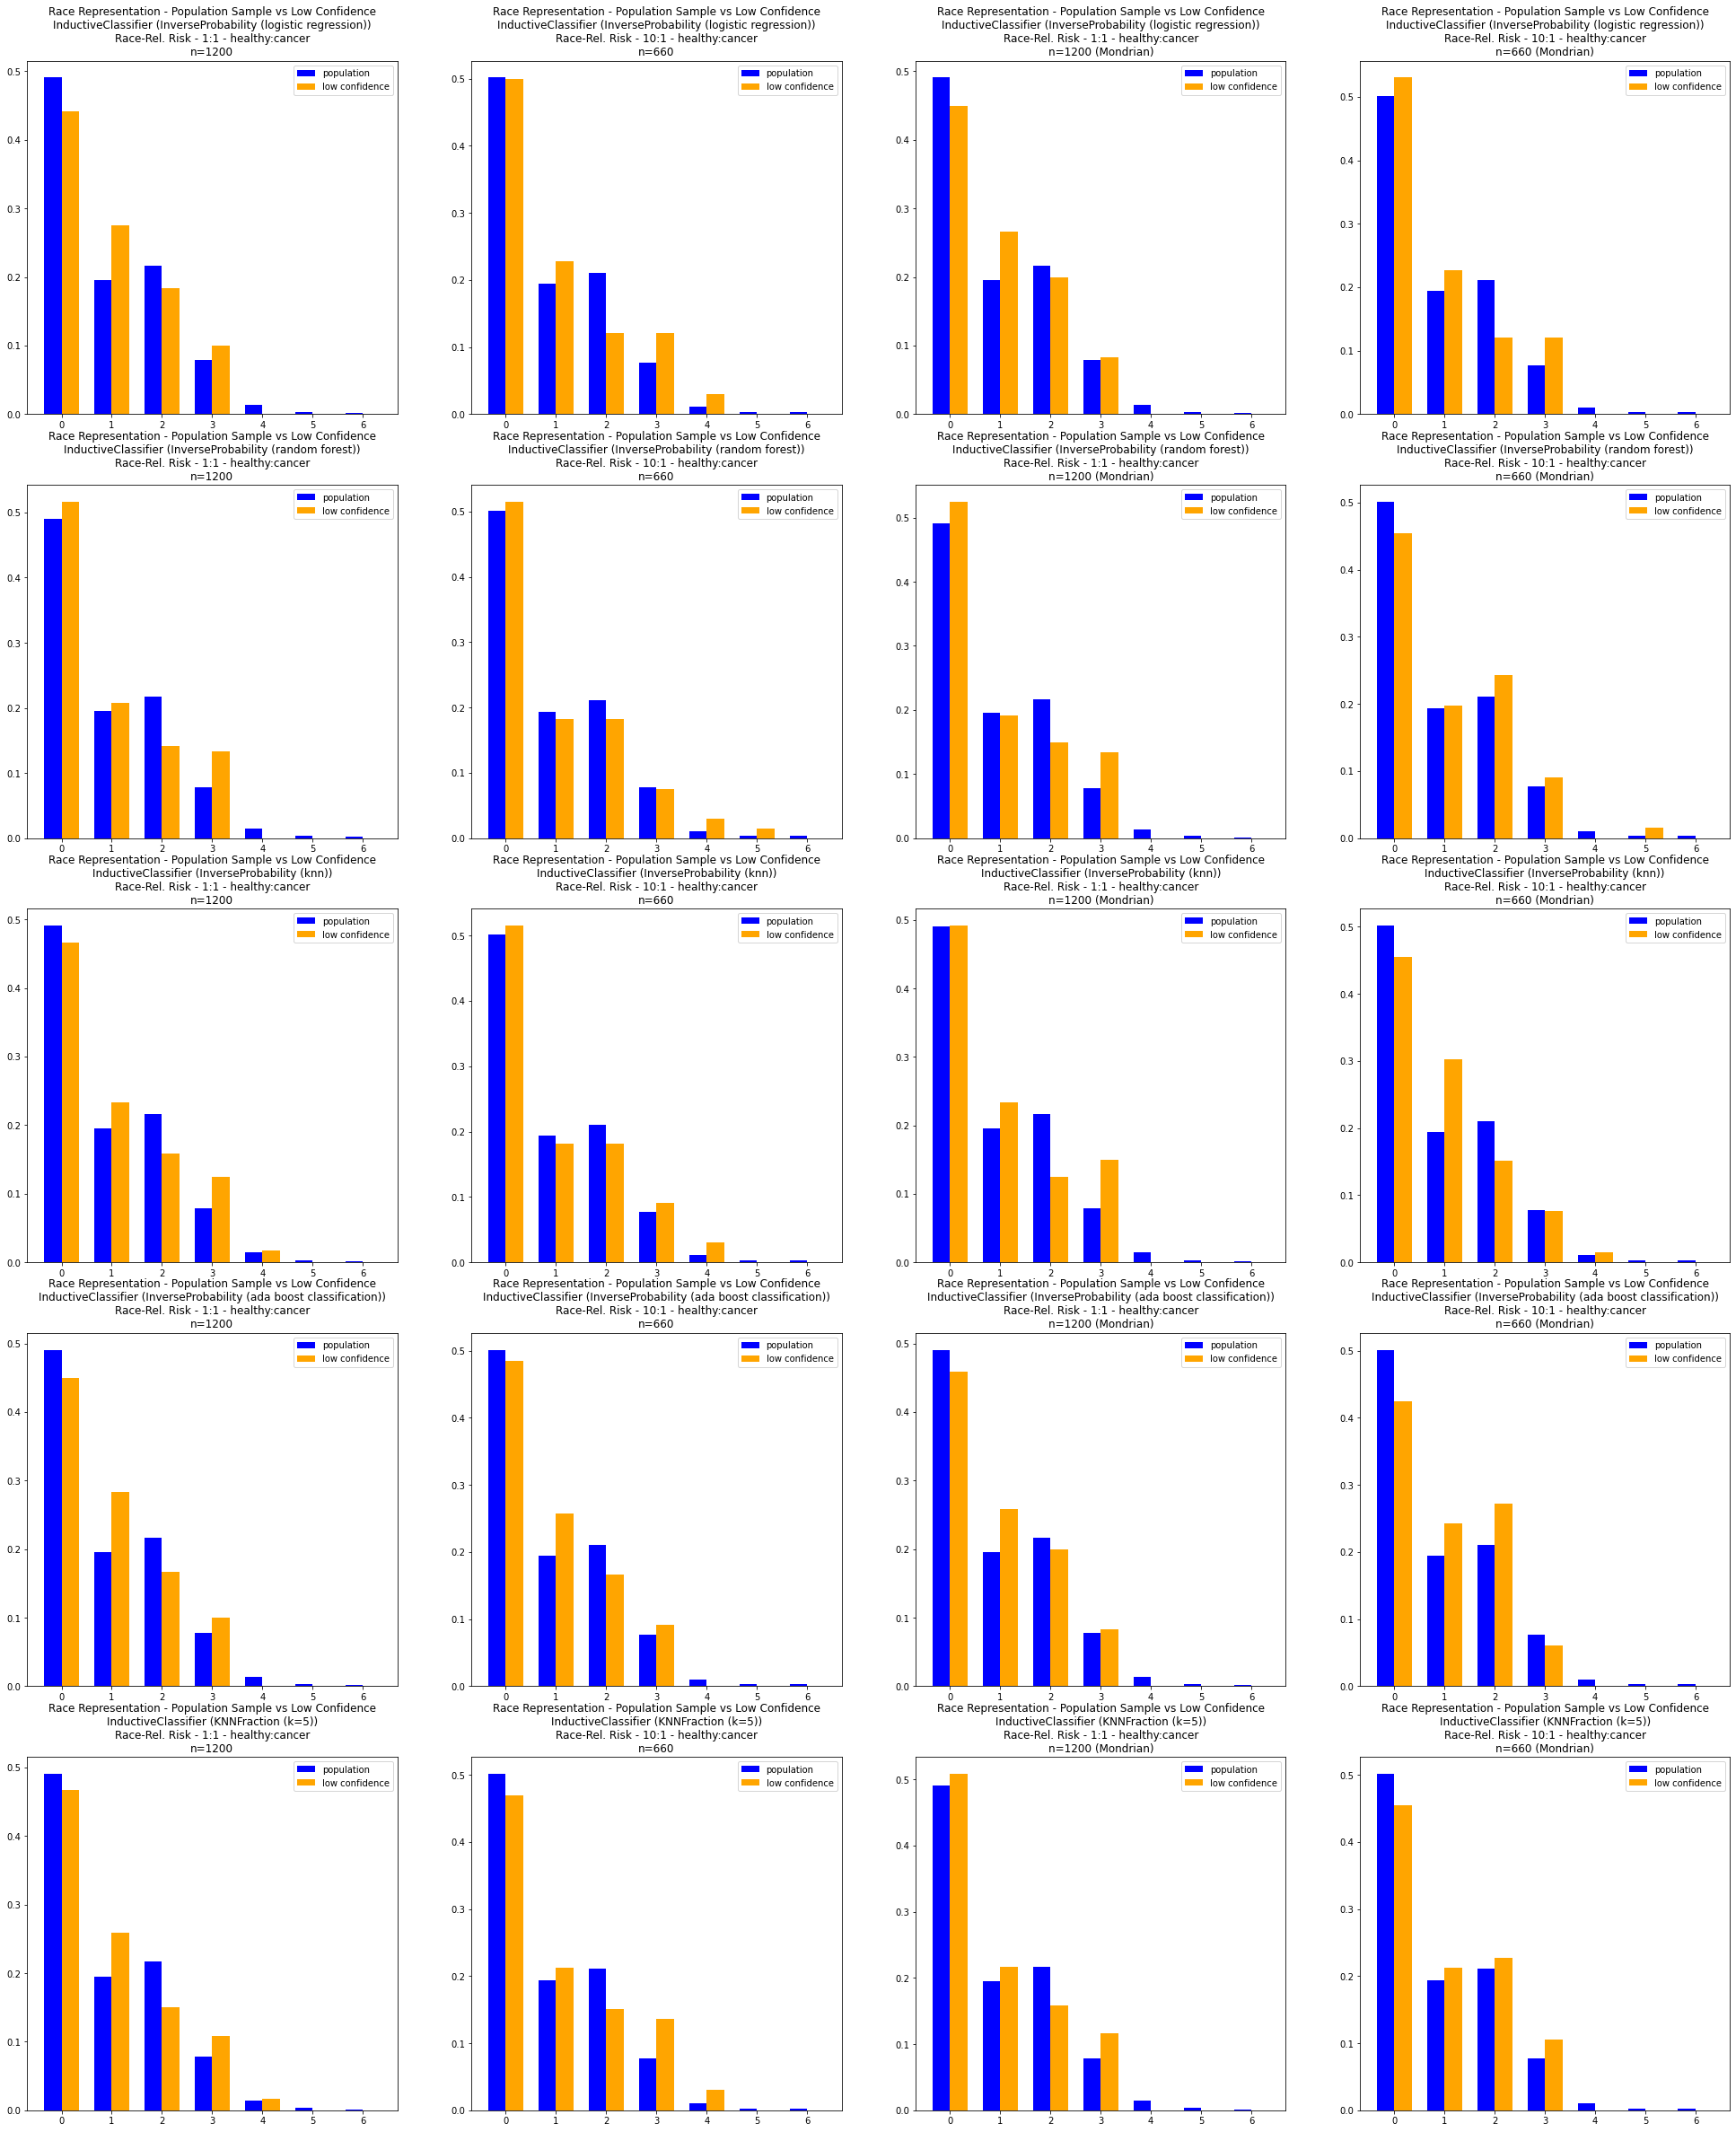

In [725]:
experiments = [util.read_experiment('./results/logistic_regression_1200_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_1200_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_1200_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_1200_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_1200_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_1200_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_1200_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_1200_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_1200_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_1200_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_1200_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_1200_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_1200_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_1200_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_rrr_imbalanced_mondrian_experiment.csv')]


col = 4
row = 5

fig, axs = plt.subplots(row, col)
fig.set_figheight(42)
fig.set_figwidth(34)

for i in range(row * col):
    row_idx = i // col
    col_idx = i % col
    util.plot_race_representation_from_experiment(experiments[i], ax=axs[row_idx, col_idx])

#### Observation:

- 

----

Note: the full set of predictions are available in each experiments' `'df'` column (e.g., `experiments[0].loc[0, 'df']`)

In [726]:
pd.concat(experiments).loc[:, 'confidence':'classifier']

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier
0,0.992831,0.507202,0.900833,0.062500,0.937500,0.900833,0.00,Race-Rel. Risk - 1:1 - healthy:cancer,False,logistic regression
0,0.997786,0.502363,0.901515,0.096970,0.903030,0.901515,0.00,Race-Rel. Risk - 10:1 - healthy:cancer,False,logistic regression
0,0.991932,0.508218,0.901667,0.061667,0.938333,0.901667,0.00,Race-Rel. Risk - 1:1 - healthy:cancer,True,logistic regression
0,0.983520,0.505915,0.903030,0.090909,0.909091,0.903030,0.00,Race-Rel. Risk - 10:1 - healthy:cancer,True,logistic regression
0,0.998631,0.810388,0.925833,0.074167,0.925833,0.925833,0.00,Race-Rel. Risk - 1:1 - healthy:cancer,False,random forest
0,0.998398,0.920210,0.915152,0.084848,0.915152,0.915152,0.00,Race-Rel. Risk - 10:1 - healthy:cancer,False,random forest
0,0.997786,0.810696,0.925833,0.074167,0.925833,0.925833,0.00,Race-Rel. Risk - 1:1 - healthy:cancer,True,random forest
0,0.984966,0.941458,0.966667,0.033333,0.966667,0.966667,0.00,Race-Rel. Risk - 10:1 - healthy:cancer,True,random forest
0,0.983678,0.733464,0.925000,0.000000,1.000000,0.925000,0.00,Race-Rel. Risk - 1:1 - healthy:cancer,False,knn
0,0.994556,0.879602,0.937879,0.037879,0.962121,0.937879,0.00,Race-Rel. Risk - 10:1 - healthy:cancer,False,knn


----

----

### `n=12000` Experiments (RRR)

----

__Read in and Plot Experiment Results__


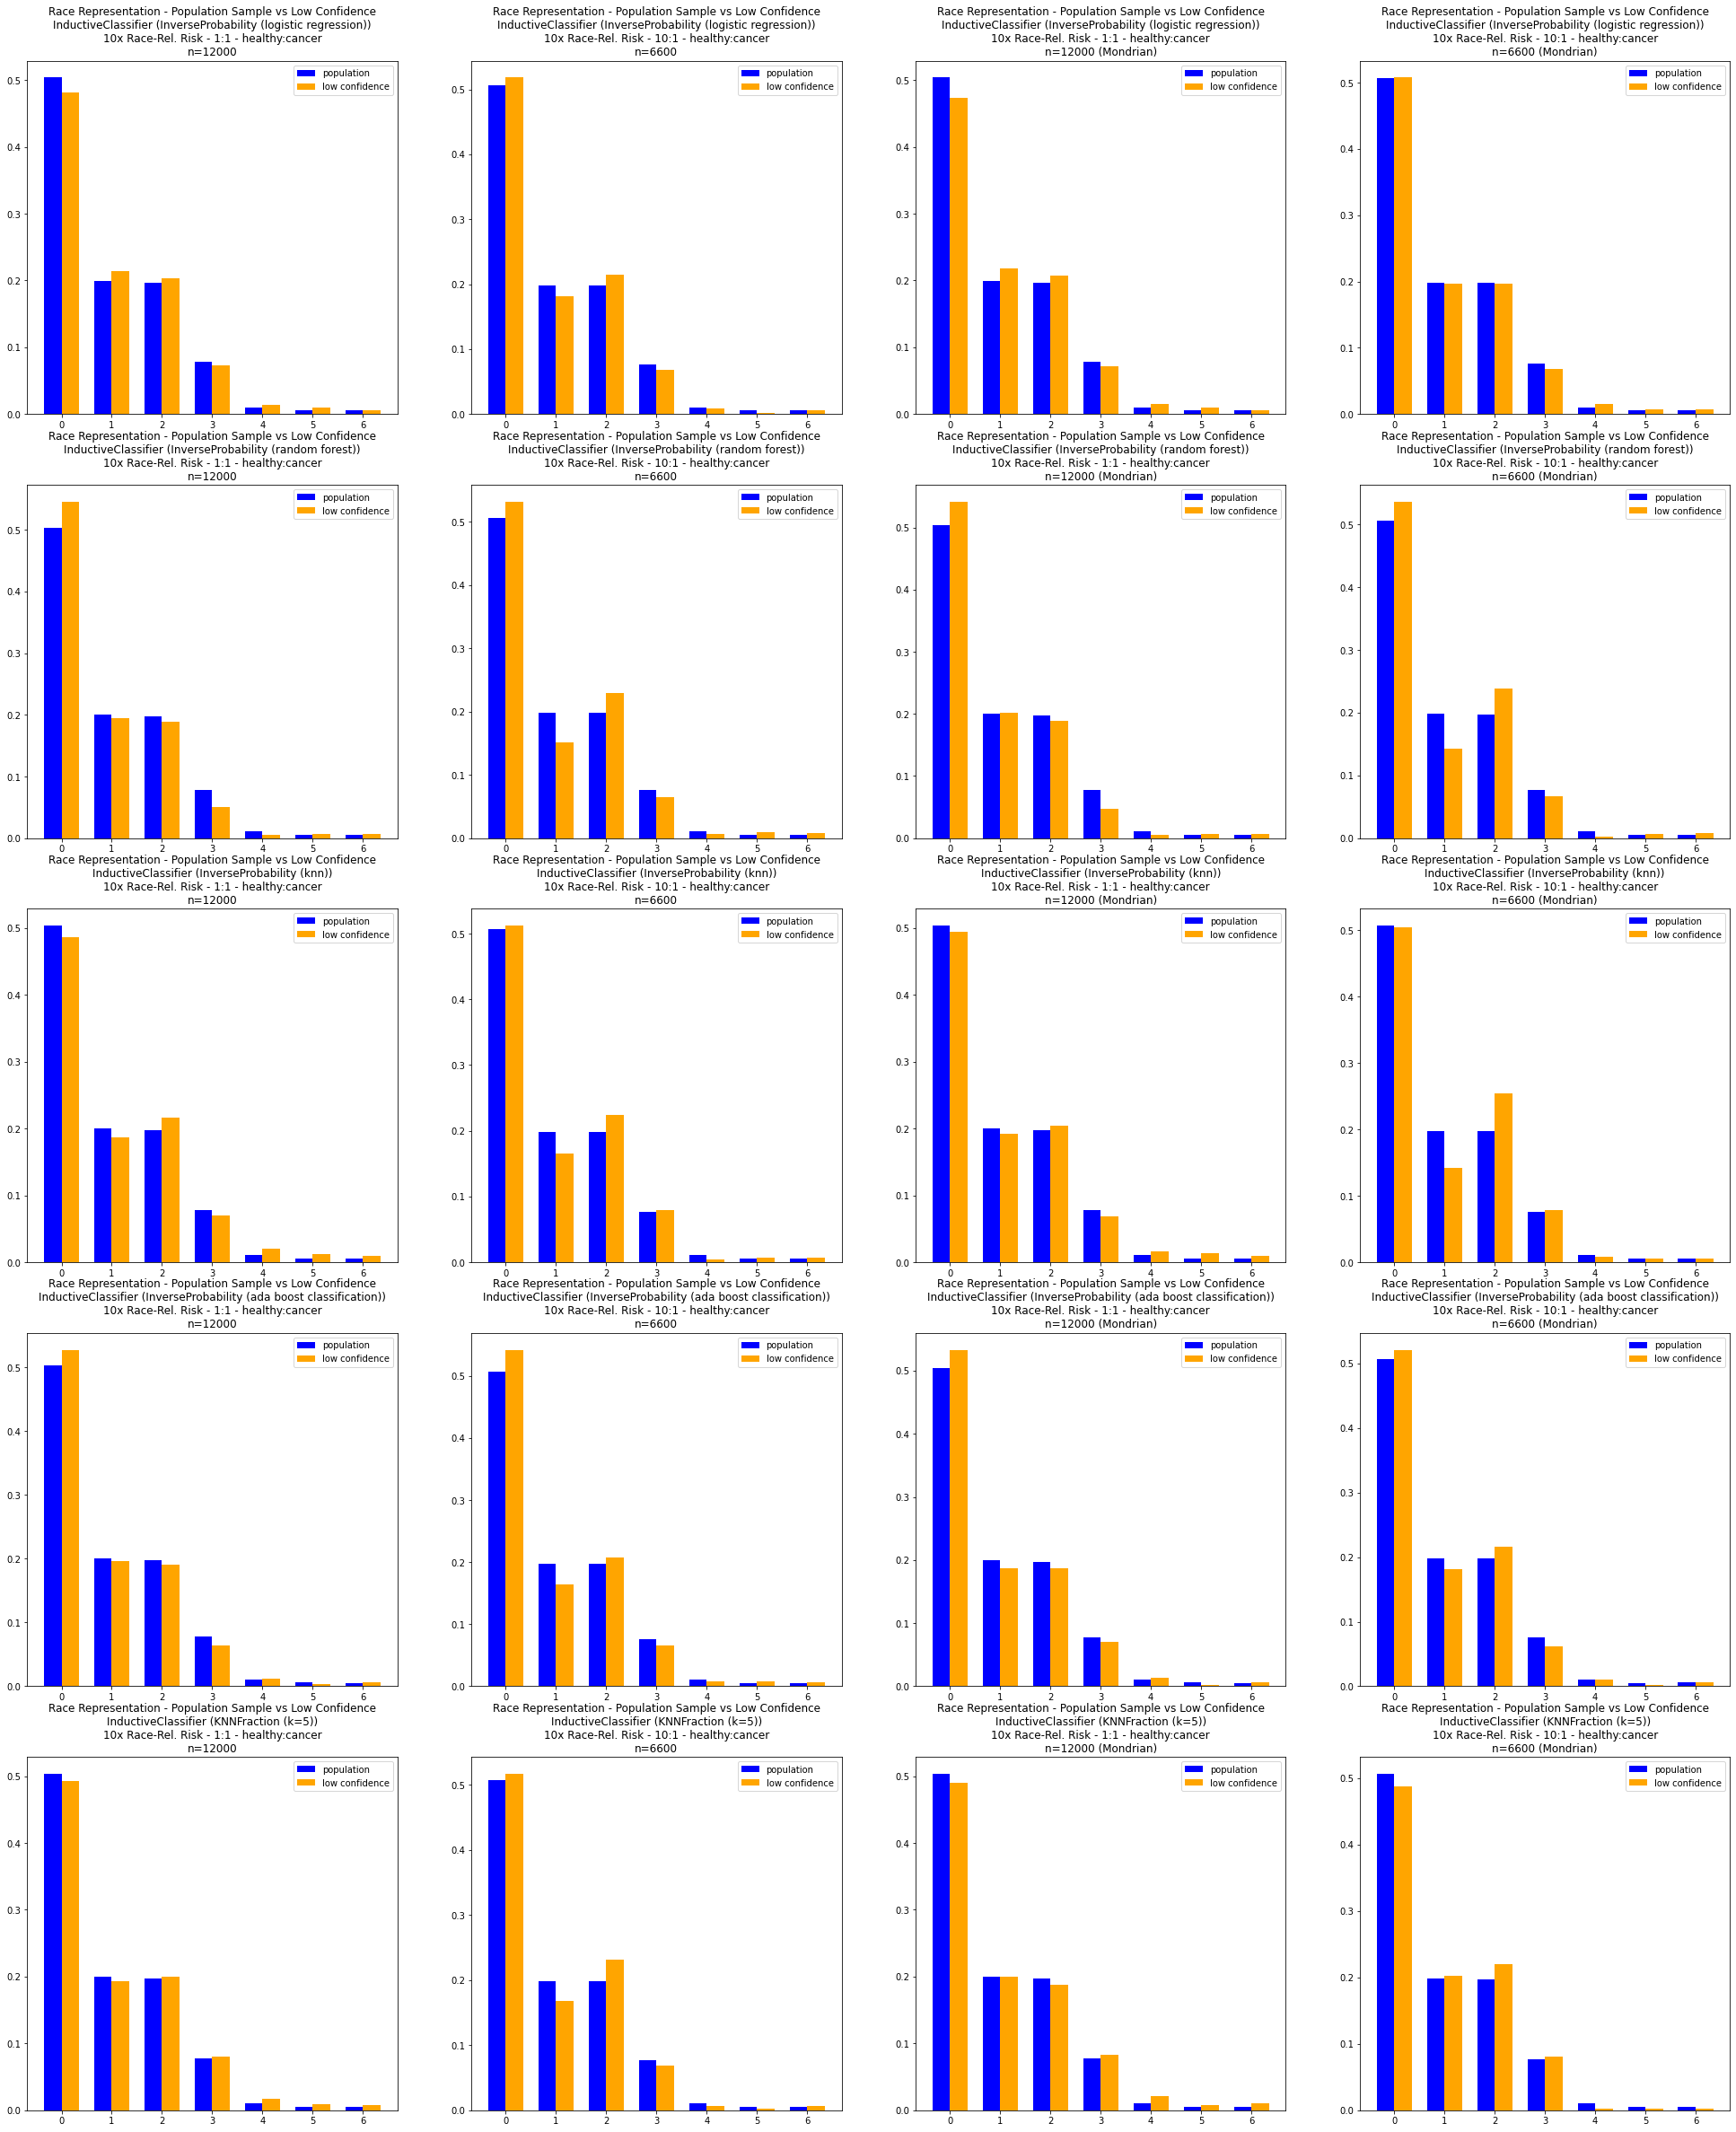

In [727]:
experiments = [util.read_experiment('./results/logistic_regression_12000_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_12000_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_imbalanced_mondrian_experiment.csv')]


col = 4
row = 5

fig, axs = plt.subplots(row, col)
fig.set_figheight(42)
fig.set_figwidth(34)

for i in range(row * col):
    row_idx = i // col
    col_idx = i % col
    util.plot_race_representation_from_experiment(experiments[i], ax=axs[row_idx, col_idx])    

In [728]:
pd.concat(experiments).loc[:, 'confidence':'classifier']

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier
0,0.992010,0.508067,0.900167,0.040417,0.959583,0.900167,0.000000,10x Race-Rel. Risk - 1:1 - healthy:cancer,False,logistic regression
0,0.998055,0.502107,0.900455,0.091667,0.908333,0.900455,0.000000,10x Race-Rel. Risk - 10:1 - healthy:cancer,False,logistic regression
0,0.991918,0.508247,0.900167,0.040333,0.959667,0.900167,0.000000,10x Race-Rel. Risk - 1:1 - healthy:cancer,True,logistic regression
0,0.990883,0.507876,0.900606,0.043182,0.956818,0.900606,0.000000,10x Race-Rel. Risk - 10:1 - healthy:cancer,True,logistic regression
0,0.997214,0.802216,0.908500,0.078833,0.921167,0.908500,0.000000,10x Race-Rel. Risk - 1:1 - healthy:cancer,False,random forest
0,0.999554,0.902092,0.901818,0.098182,0.901818,0.901818,0.000000,10x Race-Rel. Risk - 10:1 - healthy:cancer,False,random forest
0,0.997116,0.802298,0.908500,0.078833,0.921167,0.908500,0.000000,10x Race-Rel. Risk - 1:1 - healthy:cancer,True,random forest
0,0.997791,0.908887,0.926515,0.070606,0.929394,0.926515,0.000000,10x Race-Rel. Risk - 10:1 - healthy:cancer,True,random forest
0,0.986466,0.789618,0.930333,0.000000,1.000000,0.930333,0.000000,10x Race-Rel. Risk - 1:1 - healthy:cancer,False,knn
0,0.996921,0.882049,0.939394,0.044545,0.955455,0.939394,0.000000,10x Race-Rel. Risk - 10:1 - healthy:cancer,False,knn


----

## Experiments:
- `n=1200` Race-Relative Risk (RRR) Race-Conditional Inductive Conformal Predictor
    - __Mondrian__ = __False__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
    - __Mondrian__ = __True__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
- `n=12000` Race-Relative Risk (RRR) Race-Conditional Inductive Conformal Predictor
    - __Mondrian__ = __False__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer
    - __Mondrian__ = __True__
        - __Balanced__ = __1:1__ healthy:cancer
        - __Imbalanced__ = __10:1__ healthy:cancer

----

----

----

### `n=1200` Experiments (RRR) Race-Conditional Inductive Conformal Predictor

----

__Read in and Plot Experiment Results__


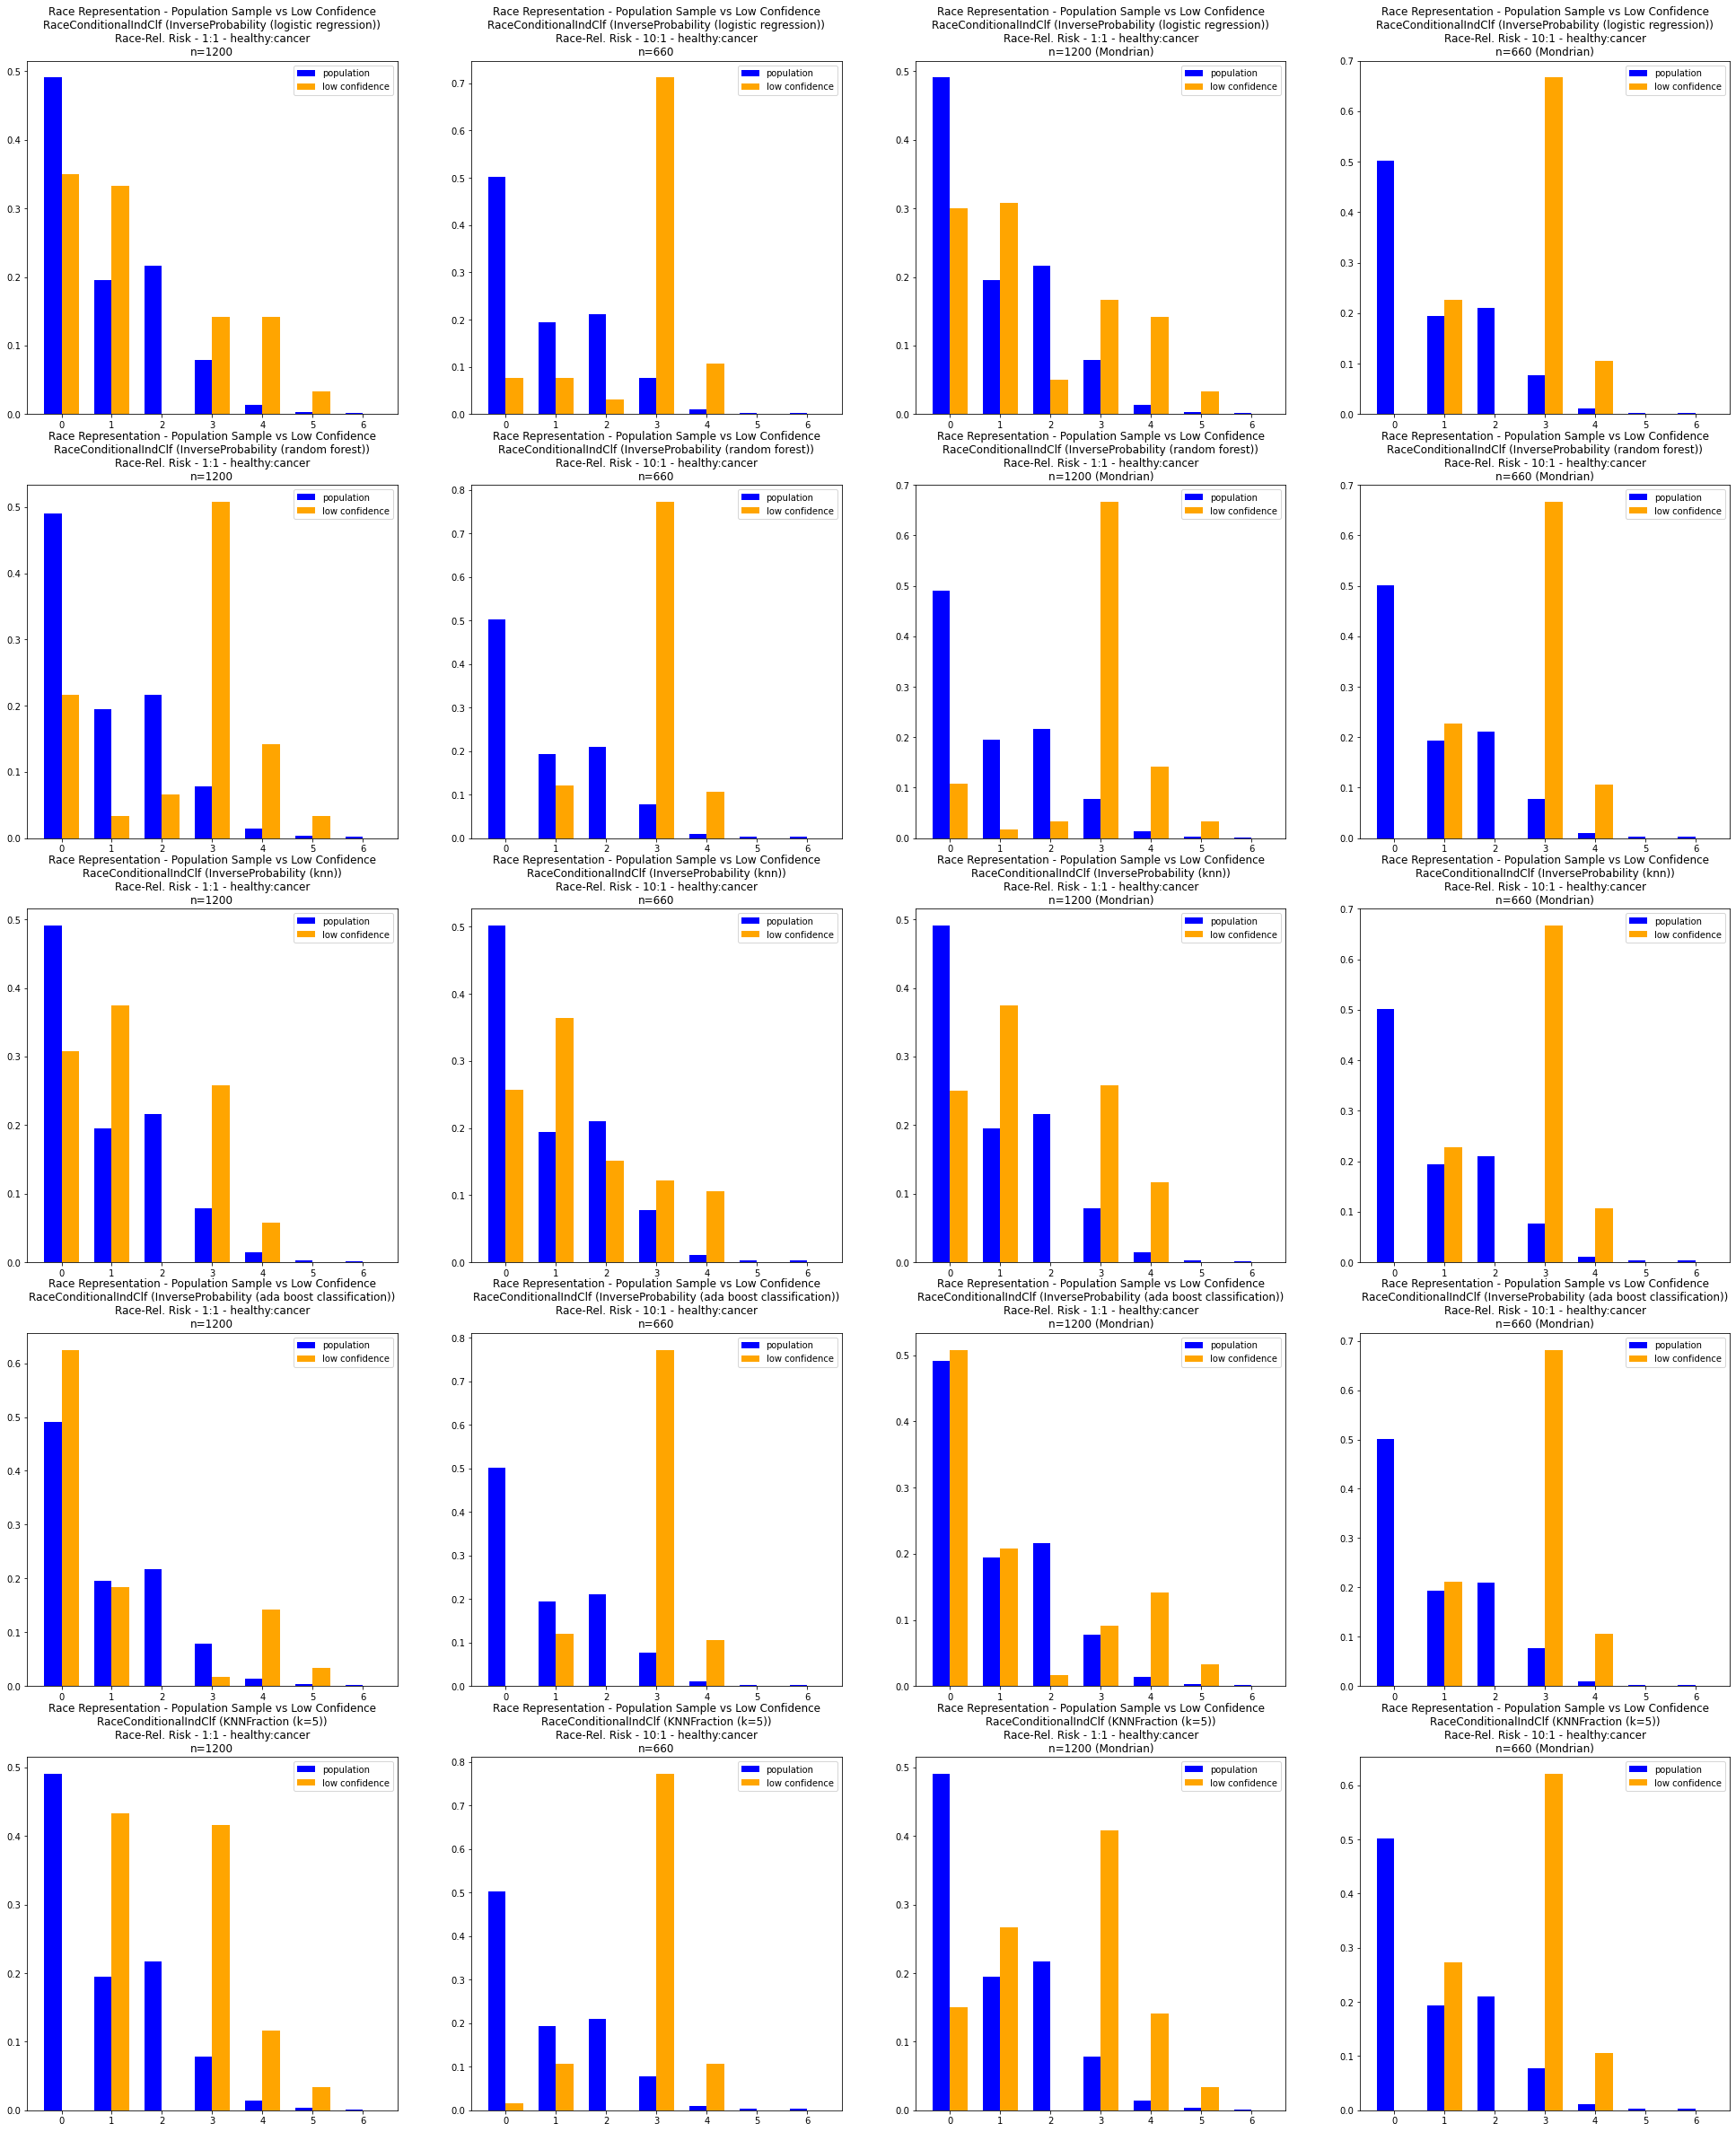

In [729]:
experiments = [util.read_experiment('./results/logistic_regression_1200_rrr_rcic_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_1200_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_1200_rrr_rcic_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_1200_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_1200_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_1200_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_1200_rrr_rcic_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_1200_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_1200_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_1200_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_1200_rrr_rcic_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_1200_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_1200_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_1200_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_1200_rrr_rcic_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_1200_rrr_rcic_imbalanced_mondrian_experiment.csv')]


col = 4
row = 5

fig, axs = plt.subplots(row, col)
fig.set_figheight(42)
fig.set_figwidth(34)

for i in range(row * col):
    row_idx = i // col
    col_idx = i % col
    util.plot_race_representation_from_experiment(experiments[i], ax=axs[row_idx, col_idx])

#### Observation:

- 

----

Note: the full set of predictions are available in each experiments' `'df'` column (e.g., `experiments[0].loc[0, 'df']`)

In [730]:
pd.concat(experiments).loc[:, 'confidence':'classifier']

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier
0,0.988978,0.510240,0.904167,0.052500,0.944167,0.900833,0.003333,Race-Rel. Risk - 1:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.991704,0.505644,0.903030,0.095455,0.893939,0.892424,0.010606,Race-Rel. Risk - 10:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.983799,0.514901,0.911667,0.046667,0.935833,0.894167,0.017500,Race-Rel. Risk - 1:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.942617,0.516002,0.912121,0.056061,0.868182,0.836364,0.075758,Race-Rel. Risk - 10:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.994405,0.761484,0.924167,0.075000,0.921667,0.920833,0.003333,Race-Rel. Risk - 1:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.992631,0.851985,0.924242,0.075758,0.913636,0.913636,0.010606,Race-Rel. Risk - 10:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.989458,0.764565,0.925833,0.072500,0.914167,0.912500,0.013333,Race-Rel. Risk - 1:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.942191,0.879949,0.925758,0.071212,0.851515,0.848485,0.077273,Race-Rel. Risk - 10:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.978078,0.736055,0.930000,0.005000,0.963333,0.898333,0.031667,Race-Rel. Risk - 1:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.986353,0.872932,0.922727,0.053030,0.936364,0.912121,0.010606,Race-Rel. Risk - 10:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability


----

----

### `n=12000` Experiments (RRR) Race-Conditional Inductive Conformal Predictor

----

__Read in and Plot Experiment Results__


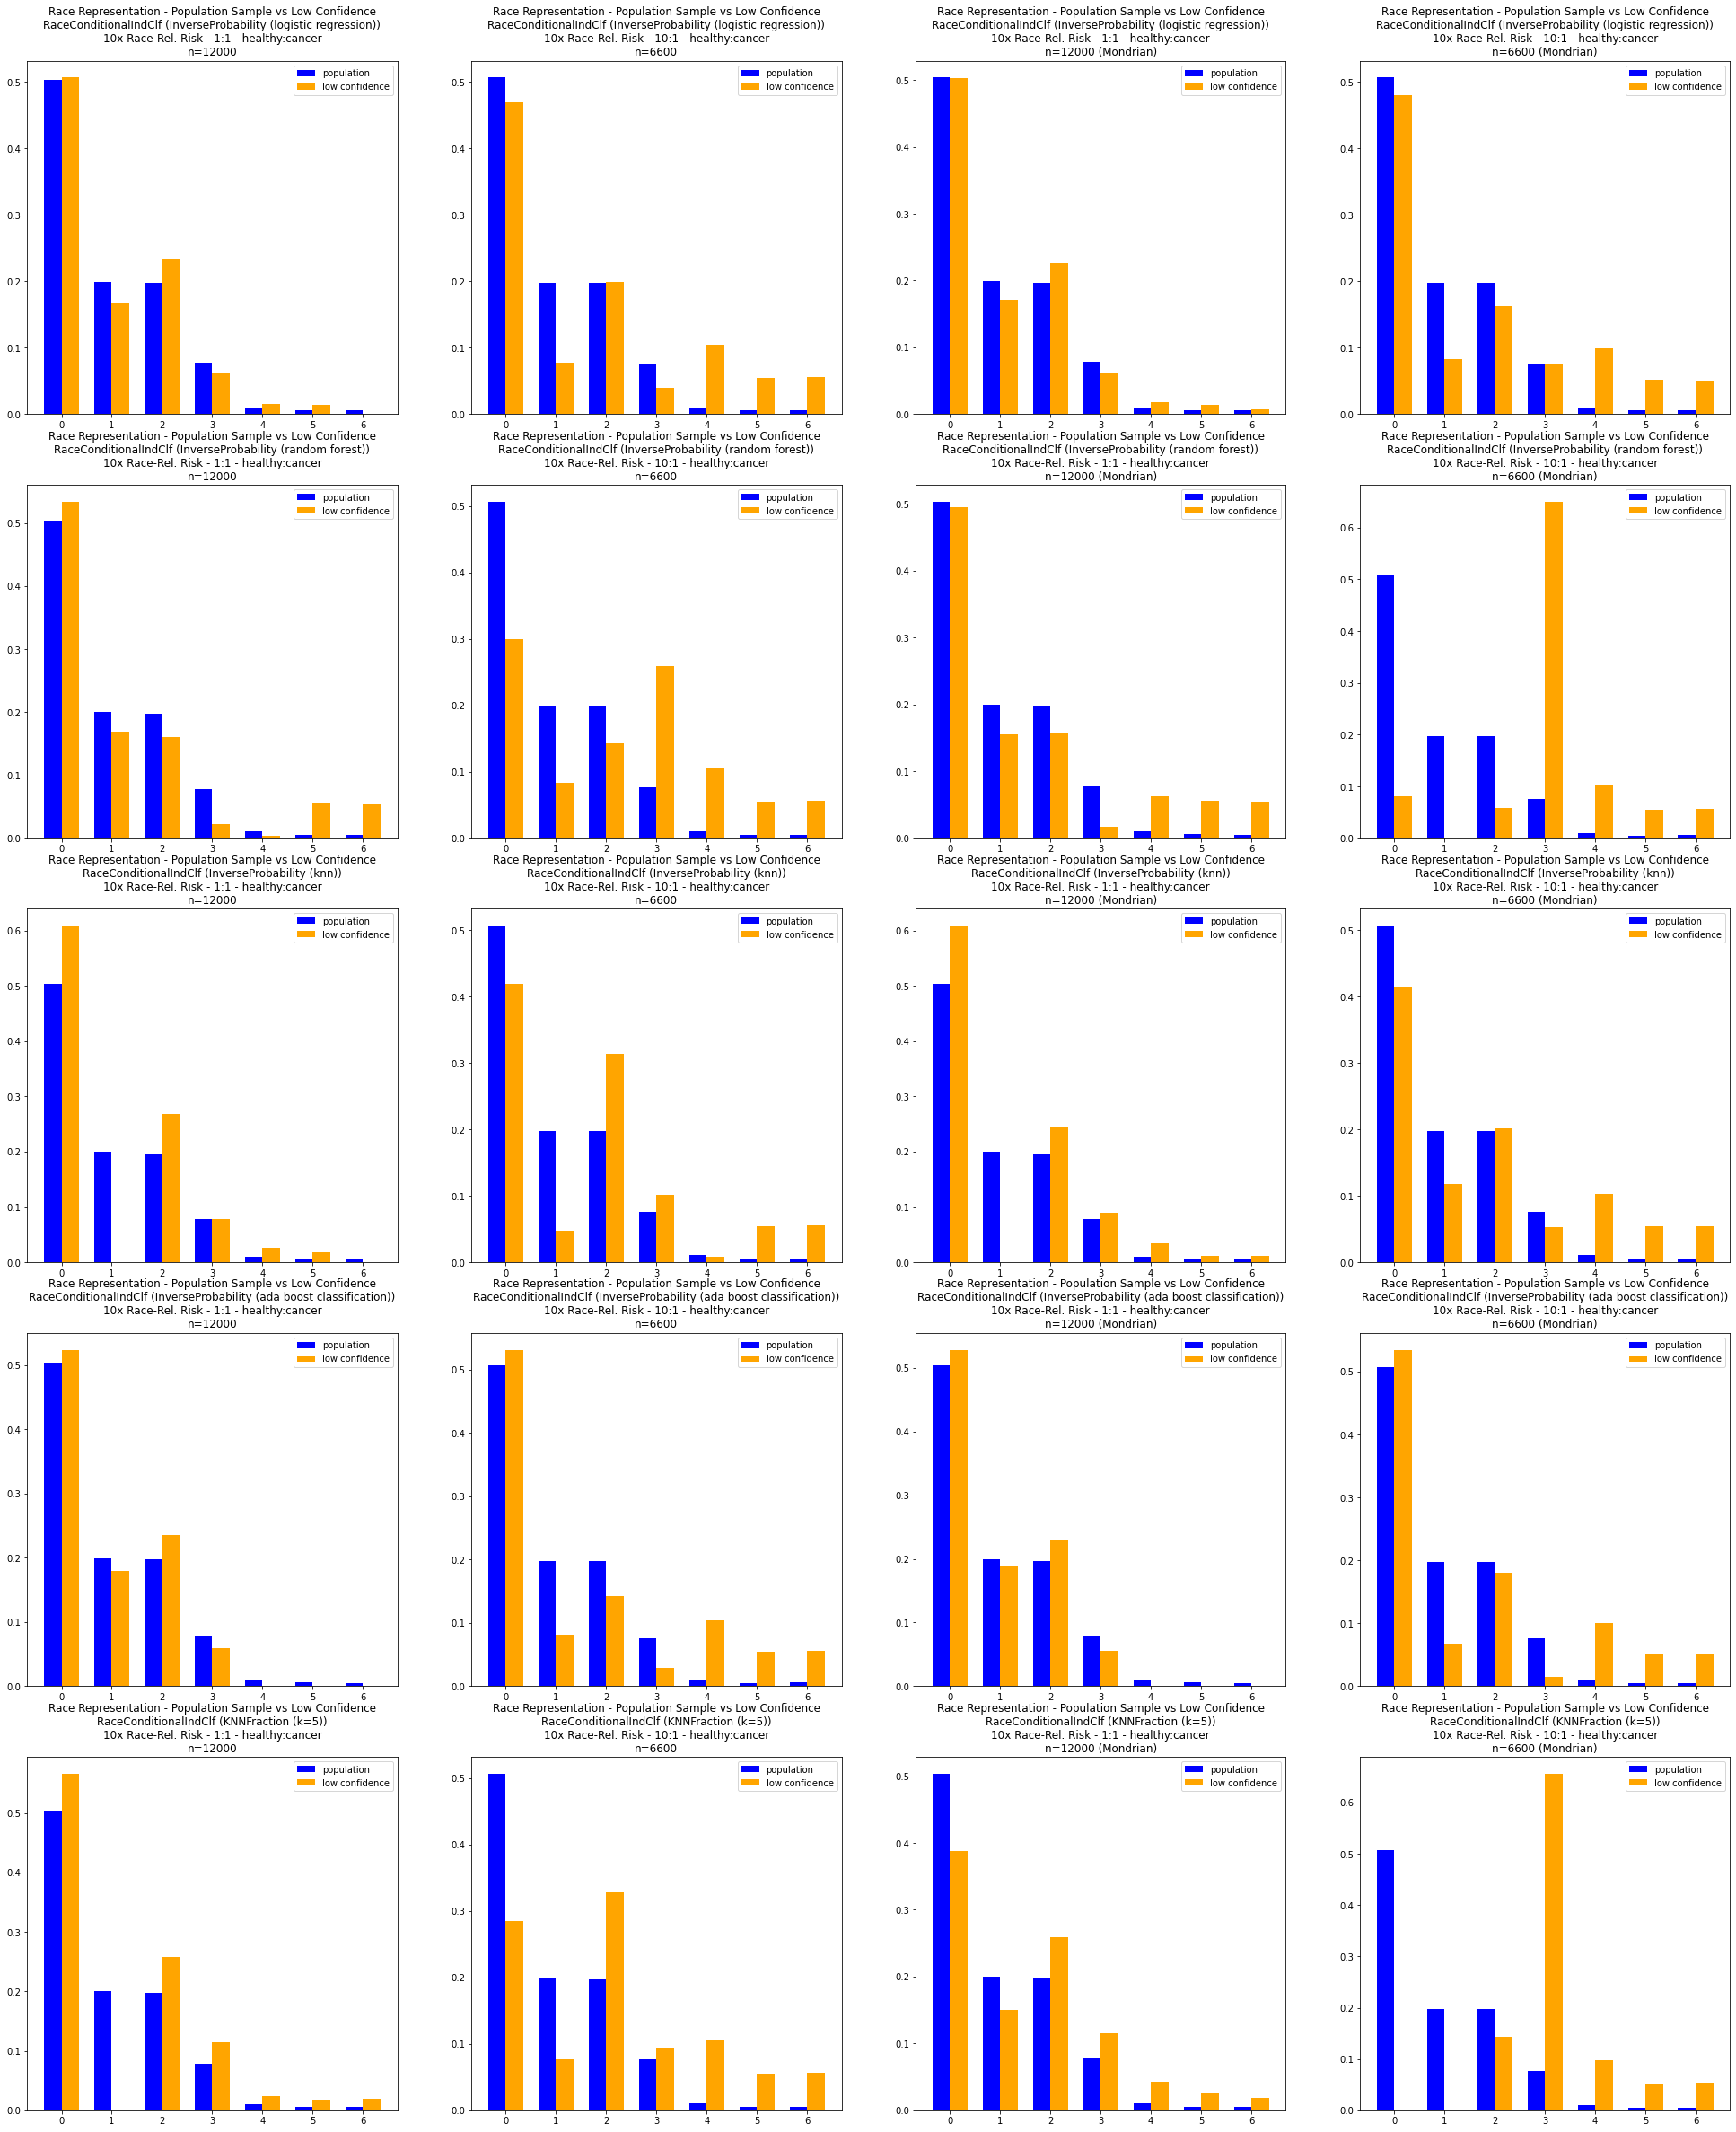

In [731]:
experiments = [util.read_experiment('./results/logistic_regression_12000_rrr_rcic_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_12000_rrr_rcic_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_12000_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_12000_rrr_rcic_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_12000_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_12000_rrr_rcic_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_12000_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_rcic_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_12000_rrr_rcic_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_rcic_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_rcic_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_rcic_imbalanced_mondrian_experiment.csv')]


col = 4
row = 5

fig, axs = plt.subplots(row, col)
fig.set_figheight(42)
fig.set_figwidth(34)

for i in range(row * col):
    row_idx = i // col
    col_idx = i % col
    util.plot_race_representation_from_experiment(experiments[i], ax=axs[row_idx, col_idx])    

In [732]:
pd.concat(experiments).loc[:, 'confidence':'classifier']

,confidence,credibility,verdict,empty,single,single_correct,multiple,data,mondrian,classifier
0,0.991632,0.508571,0.901250,0.040667,0.959167,0.901083,0.000167,10x Race-Rel. Risk - 1:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.997119,0.503335,0.901970,0.089848,0.910000,0.901818,0.000152,10x Race-Rel. Risk - 10:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.991002,0.509396,0.902750,0.038583,0.961083,0.902417,0.000333,10x Race-Rel. Risk - 1:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.981742,0.510588,0.903030,0.037273,0.943788,0.884091,0.018939,10x Race-Rel. Risk - 10:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.996530,0.795749,0.905750,0.081333,0.918667,0.905750,0.000000,10x Race-Rel. Risk - 1:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.998619,0.894139,0.926515,0.073182,0.926818,0.926515,0.000000,10x Race-Rel. Risk - 10:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.995921,0.796127,0.906417,0.080917,0.919083,0.906417,0.000000,10x Race-Rel. Risk - 1:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.987221,0.904765,0.923788,0.071667,0.908485,0.903939,0.019848,10x Race-Rel. Risk - 10:1 - healthy:cancer,True,RaceConditionalIndClf - InverseProbability
0,0.985596,0.789826,0.930750,0.000000,0.995583,0.926333,0.004417,10x Race-Rel. Risk - 1:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability
0,0.995760,0.880829,0.939091,0.044697,0.953939,0.937727,0.001364,10x Race-Rel. Risk - 10:1 - healthy:cancer,False,RaceConditionalIndClf - InverseProbability


Observations:


----

----

----

----

----

----

----

----

----

----

----

# Visually Representing Individual Prediction

In [117]:
import plotly.graph_objects as go

def plot_prediction_uncertainty(s):
    pred = s
    min_cred = 5
    min_conf = 90
    conf = pred.confidence*100
    cred = pred.credibility*100
    second_most_cred = (1 - pred.credibility) * 100
    cred_threshold_clr = 'red' if cred < min_cred else 'lime'
    conf_color = 'red' if conf < min_conf else 'green'

    fig =go.Figure(go.Indicator(
        domain={'x': [0, 1], 'y': [0, 1]},
        value=conf,
        mode='gauge+number+delta',
        title={'text':'Certainty'},
        delta={'reference':second_most_cred},
        gauge={'axis': {'range': [None,100]},
               'steps': [
                   {'range': [0,min_cred], 'color': 'tomato'},
                   {'range': [min_conf,100], 'color': 'lightgray'}],
               'threshold': {'line': {'color': cred_threshold_clr, 'width': 4}, 'thickness': 0.75, 'value': cred}}))
    fig.show()

----

### __Highest Confidence Prediction__

In [118]:
df = util.sort_reindex(experiments[0].loc[0, 'df'])
pred_high = df.iloc[0, :]
df.head(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
0,['1'],0.999917,1.0,0.1,"[(8.332638946754438e-05, '0'), (1.0, '1')]",True,3.673303,3,0,-0.48654,-0.586219,0,0,1


In [663]:
plot_prediction_uncertainty(pred_high)

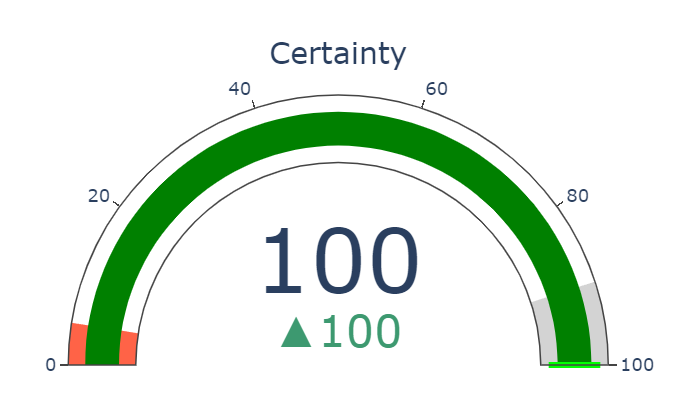

In [137]:
# display plotly graph in print/PDF
from IPython.display import Image
Image(filename='C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/source/Notebooks/conformal_pred_high_conf.PNG')

----

### __Lowest Confidence Prediction__

In [120]:
pred_low = df.iloc[-1, :]
df.tail(1)

,classes,confidence,credibility,eps,p,verdict,T1,N_Biop,HypPlas,AgeMen,Age1st,N_Rels,Race,class
11999,[],0.92209,0.07791,0.1,"[(0.07791017415215398, '0'), (0.07791017415215...",False,-0.293725,2,0,2.407616,-0.416625,0,0,0


In [662]:
plot_prediction_uncertainty(pred_low)

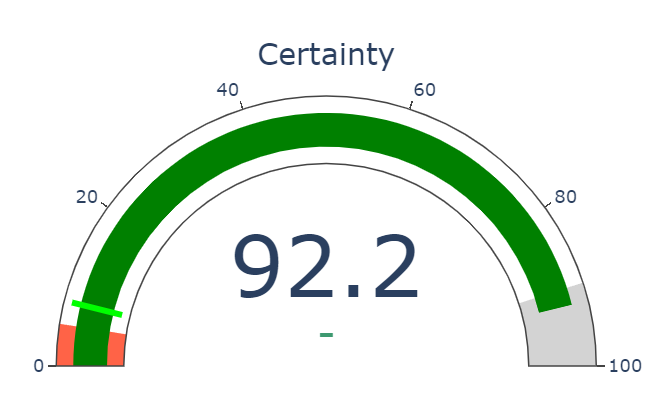

In [136]:
# display plotly graph in print/PDF
Image(filename='C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/source/Notebooks/conformal_pred_low_conf.PNG')

-----

----

### __Lowest Confidence Prediction (`credibility` modified below threshold)__

In [127]:
pred_lower = pred_low.copy()
pred_lower['credibility'] = 0.04321
pred_lower = pd.DataFrame(pred_lower)

In [660]:
plot_prediction_uncertainty(pred_low)

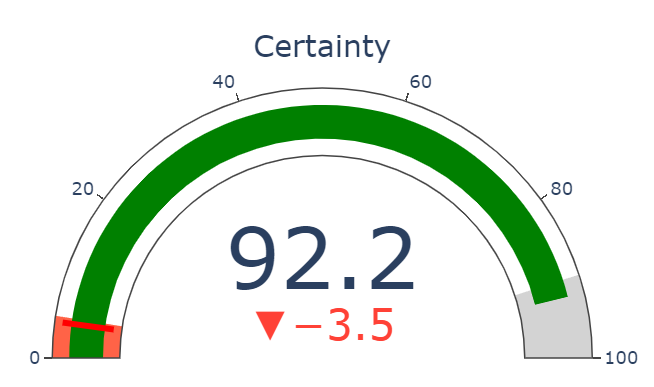

In [139]:
# display plotly graph in print/PDF
Image(filename='C:/Users/Bob/CHPC/conformal_prediction/vigilant-computing-machine/source/Notebooks/conformal_pred_low_conf_lower_cred.PNG')

----

----

----

----

----

# Possibly Agnostic Baseline Threshold 
(viable recommended starting point, per seems consistent among highly-varying experiments/setups)
- __Confidence__
    - __$X$ Percentile Confidence value among Ensemble/Experiments' $X$ Percentile Confidence value in LDR__
        - LDR = Lower-Decile Range of Predictions' Confidence
- __Credibility__
    - __$X$ Percentile Credibility value among Ensemble/Experiments' $X$ Percentile Credibility value in LDR__
        - LDR = Lower-Decile Range of Predictions' Credibility
----

Investigating LDR of both Confidence & Credibility further below (orange/blue overlap) contributed to possible findings presented here

----

In [749]:
def plot_prediction(preds_list_s, min_conf=None, min_cred=None, title=None):
    fig,ax = plt.subplots()
    
    confs = []
    creds = []
    label_x = []
    label_y = []
    error_x = []
    error_y = []
    for i,pred_series in enumerate(preds_list_s):
        confs.append(pred_series.confidence * -1)
        creds.append(pred_series.credibility)
        classes = [int(c) for c in pred_series.classes]
        true_class = int(pred_series.loc['class'])
        label_x.append(i)
        label_y.append(true_class)
        if true_class not in classes:
            error_x.append(i)
            if true_class == 0:
                error_y.append(1)
            else:
                error_y.append(0)
    
    x = list(range(len(confs)))
    ax.scatter(x, creds, marker='o', color='b', clip_on=False, label='Cred', zorder=2)
    ax.scatter(x, confs, marker='o', color='g', clip_on=False, label='Conf', zorder=2)
    ax.scatter(error_x, error_y, marker='X', color='r', clip_on=False, label='Error', zorder=3, s=120)
    ax.scatter(label_x, label_y, marker='o', color='k', clip_on=False, label='Label', zorder=4)
    
    ax.legend(bbox_to_anchor=(1.204, 1), loc='upper right')

    markerline, stemlines, baseline = plt.stem(range(len(creds)), creds)
    conf_stemlines = stemlines
    plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'linewidth', 0.25)
    plt.setp(stemlines, 'color', 'b')
    plt.setp(stemlines, 'linewidth', 4)
    plt.setp(markerline, 'color', 'b')
    markerline, stemlines, baseline = plt.stem(range(len(confs)), confs)
    plt.setp(baseline, 'color', 'k')
    plt.setp(baseline, 'linewidth', 0.25)
    plt.setp(stemlines, 'color', 'g')
    plt.setp(stemlines, 'linewidth', 4)
    plt.setp(markerline, 'color', 'g')
    cred_stemlines = stemlines
    
    ax.scatter(error_x, error_y, marker='x', color='k', clip_on=False, label='Error', zorder=3, s=100, linewidth=0.5)
    if min_cred is not None:
        ax.hlines(min_cred, xmin=0, xmax=len(confs)-1, linewidth=1.5, linestyle='--', zorder=5, color='r')
    if min_conf is not None:
        ax.hlines(-min_conf, xmin=0, xmax=len(confs)-1, linewidth=1.5, linestyle='--', zorder=5, color='r')

    plt.ylim((-1,1))
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.set_ylabel('Probability measure\n(Confidence plotted as -Confidence),\n0/1 class label (error)')
    ax.set_xlabel('Conformal Predictors')
    if title is not None:
        ax.set_title(title)
    [spine.set_linewidth(0.25) for edge,spine in ax.spines.items()]

    plt.show()


def get_experiments_max_low_confidence(experiments):
    return [util.get_low_confidence_predictions(exp.df[0], percentile=10).confidence.max() for exp in experiments]


def get_experiments_median_low_credibility(experiments):
    return [util.get_low_credibility_predictions(exp.df[0], percentile=10).credibility.median() for exp in experiments]

def get_experiments_max_low_credibility(experiments):
    return [util.get_low_credibility_predictions(exp.df[0], percentile=10).credibility.max() for exp in experiments]

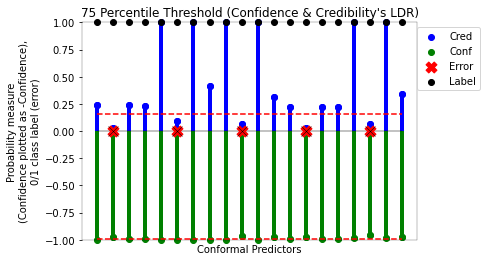

In [750]:
experiments = [util.read_experiment('./results/logistic_regression_12000_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_12000_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_imbalanced_mondrian_experiment.csv')]

idx = util.get_low_confidence_predictions(experiments[1].df[0]).head(1).index.values[0]

min_conf_among_exps_max_conf_in_low_conf_region = \
    np.percentile(get_experiments_max_low_confidence(experiments), 75)

min_cred_among_exps_median_cred_in_low_cred_region = \
    np.percentile(get_experiments_max_low_credibility(experiments), 75)

plot_prediction(preds_list_s=[exp.df[0].iloc[idx] for exp in experiments], 
                min_conf=min_conf_among_exps_max_conf_in_low_conf_region, 
                min_cred=min_cred_among_exps_median_cred_in_low_cred_region, 
                title='75 Percentile Threshold (Confidence & Credibility\'s LDR)')

# print('Note: normalized values will vary between 1:1 and 10:1 experiments\n')
# [exp.df[0].iloc[idx].loc['T1':'Race'] for exp in experiments]

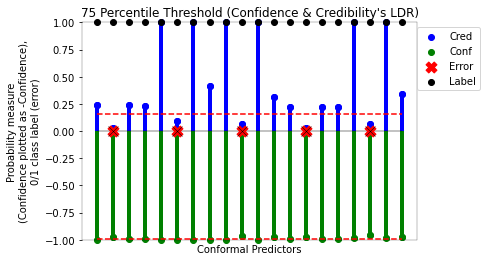

In [751]:
experiments = [util.read_experiment('./results/logistic_regression_12000_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/logistic_regression_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/rf_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/rf_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/rf_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/knn_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/ada_12000_rrr_balanced_experiment.csv'),               
               util.read_experiment('./results/ada_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/ada_12000_rrr_imbalanced_mondrian_experiment.csv'),
               
               util.read_experiment('./results/knn_fraction_12000_rrr_balanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_imbalanced_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_balanced_mondrian_experiment.csv'),
               util.read_experiment('./results/knn_fraction_12000_rrr_imbalanced_mondrian_experiment.csv')]

idx = util.get_low_confidence_predictions(experiments[1].df[0]).head(1).index.values[0]

min_conf_among_exps_max_conf_in_low_conf_region = \
    np.percentile(get_experiments_max_low_confidence(experiments), 75)

min_cred_among_exps_median_cred_in_low_cred_region = \
    np.percentile(get_experiments_max_low_credibility(experiments), 75)

plot_prediction(preds_list_s=[exp.df[0].iloc[idx] for exp in experiments], 
                min_conf=min_conf_among_exps_max_conf_in_low_conf_region, 
                min_cred=min_cred_among_exps_median_cred_in_low_cred_region,
                title='75 Percentile Threshold (Confidence & Credibility\'s LDR)')

# print('Note: normalized values will vary between 1:1 and 10:1 experiments\n')
# [exp.df[0].iloc[idx].loc['T1':'Race'] for exp in experiments]

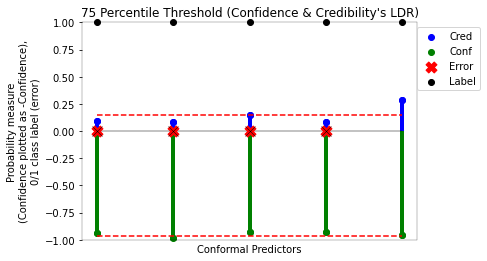

In [752]:
exps=[]
for i,x in enumerate(experiments):
    if i % 4 == 0:
        # print(i)
        # print(x.data)
        # print(x.mondrian)
        # print()
        exps.append(x)    
        

lc = util.get_low_confidence_predictions(exps[2].df[0])
idx = lc[lc.verdict==False].head(1).index.values[0]

min_conf_among_exps_max_conf_in_low_conf_region = \
    np.percentile(get_experiments_max_low_confidence(exps), 75)

min_cred_among_exps_median_cred_in_low_cred_region = \
    np.percentile(get_experiments_max_low_credibility(exps), 75)

plot_prediction(preds_list_s=[exp.df[0].iloc[idx] for exp in exps], 
                min_conf=min_conf_among_exps_max_conf_in_low_conf_region,
                min_cred=min_cred_among_exps_median_cred_in_low_cred_region,
                title='75 Percentile Threshold (Confidence & Credibility\'s LDR)')

# [exp.df[0].iloc[idx].loc['T1':'Race'] for exp in exps]

# LDR appears to tend to fall in the overlap region between correct and incorrect prediction sets for both confidence and credibility

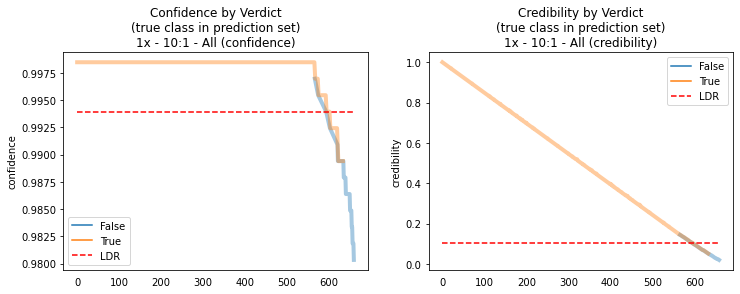

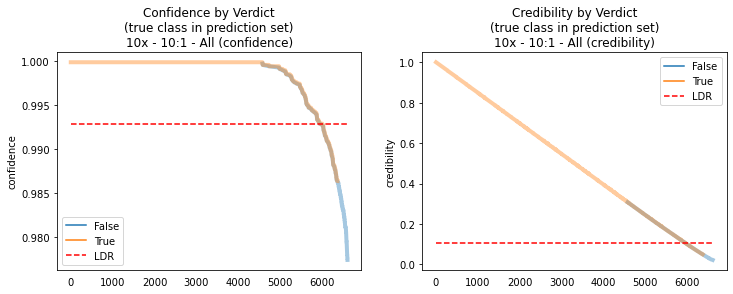

In [ ]:
a = experiment_logistic_cancer_downsampl.loc[0, 'df']
l = df_pred_logistic_signal_cancer_downsampl_ldr

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix='\n1x - 10:1 - All (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix='\n1x - 10:1 - All (credibility)')
fig.set_figwidth(12)


a = experiment_logistic_10x_downsampl.loc[0, 'df']
l = df_pred_logistic_10x_downsampl_ldr

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix='\n10x - 10:1 - All (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix='\n10x - 10:1 - All (credibility)')
fig.set_figwidth(12)

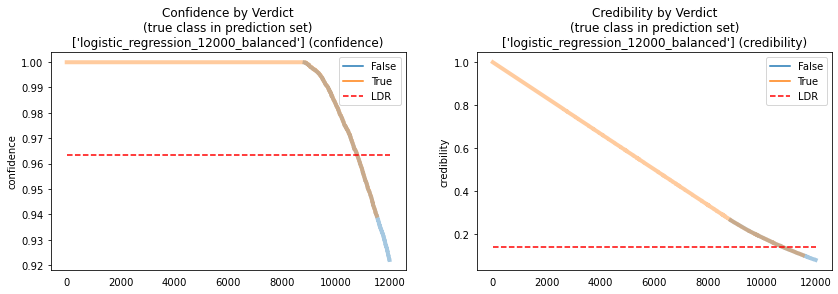

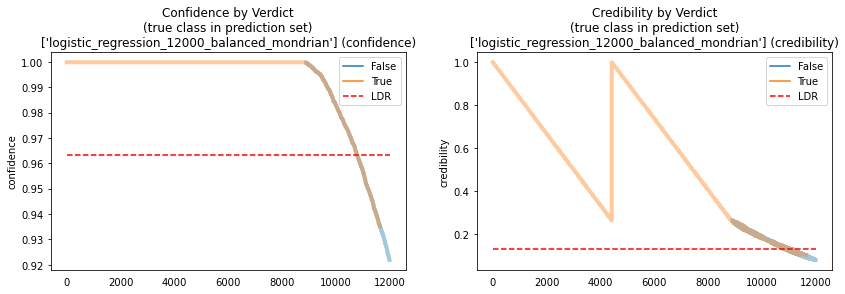

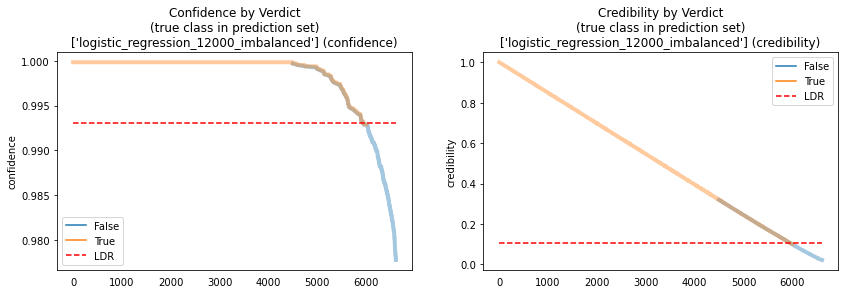

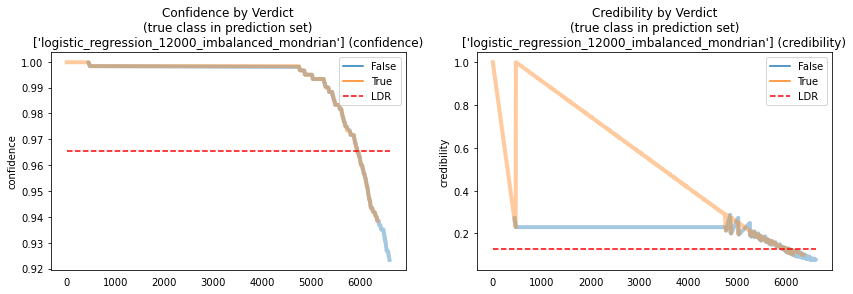

In [ ]:
# logistic 1:1
exp = experiments[0]
a = exp.df[0]
l = util.get_low_confidence_predictions(a, 10)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix=f'\n{exp.method.values} (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix=f'\n{exp.method.values} (credibility)')
fig.set_figwidth(14)


# logistic 1:1 mondrian
exp = experiments[2]
a = exp.df[0]
l = util.get_low_confidence_predictions(a, 10)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix=f'\n{exp.method.values} (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix=f'\n{exp.method.values} (credibility)')
fig.set_figwidth(14)



# logistic 10:1
exp = experiments[1]
a = exp.df[0]
l = util.get_low_confidence_predictions(a, 10)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix=f'\n{exp.method.values} (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix=f'\n{exp.method.values} (credibility)')
fig.set_figwidth(14)


# logistic 10:1 mondrian
exp = experiments[3]
a = exp.df[0]
l = util.get_low_confidence_predictions(a, 10)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix=f'\n{exp.method.values} (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix=f'\n{exp.method.values} (credibility)')
fig.set_figwidth(14)

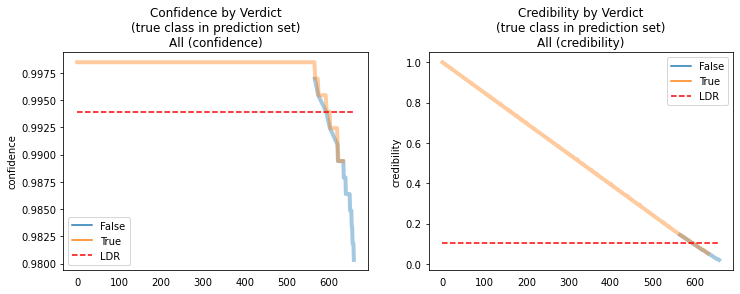

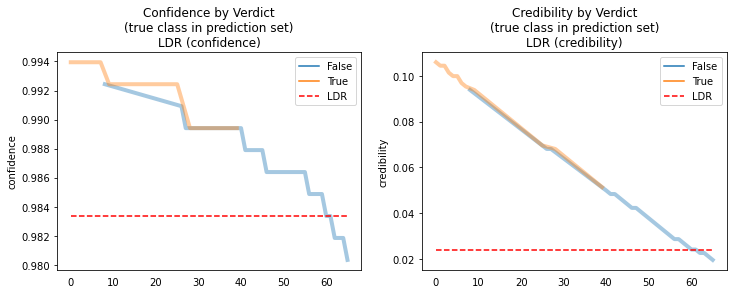

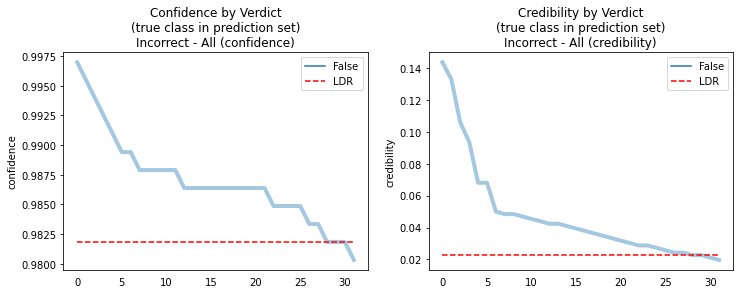

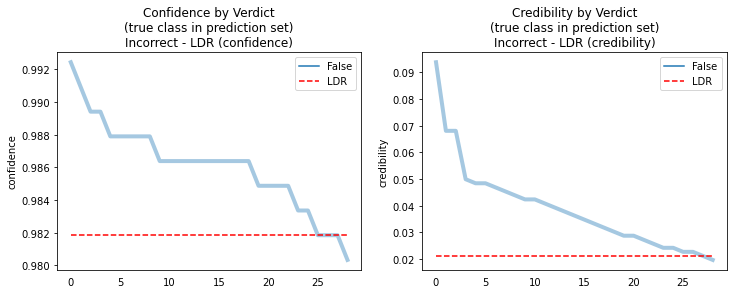

In [ ]:
a = experiment_logistic_cancer_downsampl.loc[0, 'df']
l = df_pred_logistic_signal_cancer_downsampl_ldr

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix='\nAll (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix='\nAll (credibility)')
fig.set_figwidth(12)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(l, axs[0], title_suffix='\nLDR (confidence)')
plot_credibility_by_verdict(l, axs[1], title_suffix='\nLDR (credibility)')
fig.set_figwidth(12)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(util.get_incorrect_predictions(a), axs[0], title_suffix='\nIncorrect - All (confidence)')
plot_credibility_by_verdict(util.get_incorrect_predictions(a), axs[1], title_suffix='\nIncorrect - All (credibility)')
fig.set_figwidth(12)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(util.get_incorrect_predictions(l), axs[0], title_suffix='\nIncorrect - LDR (confidence)')
plot_credibility_by_verdict(util.get_incorrect_predictions(l), axs[1], title_suffix='\nIncorrect - LDR (credibility)')
fig.set_figwidth(12)

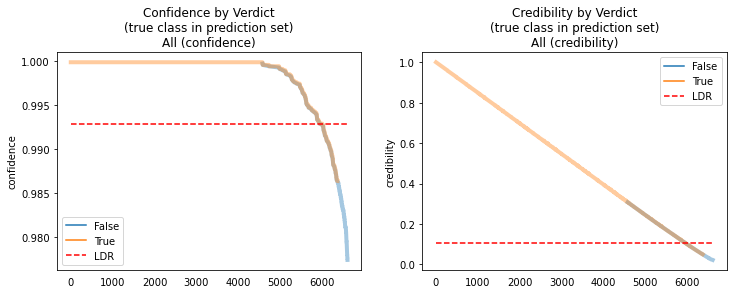

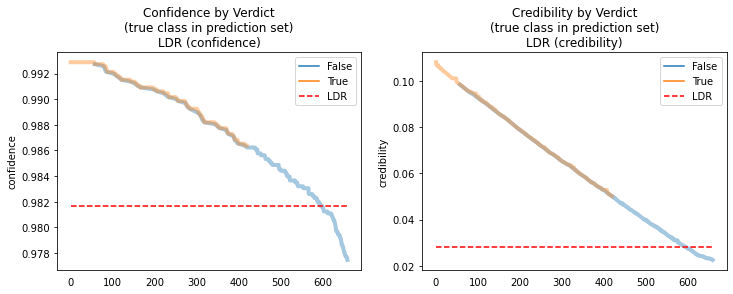

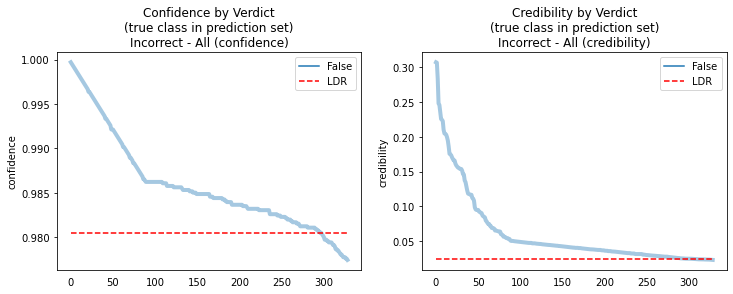

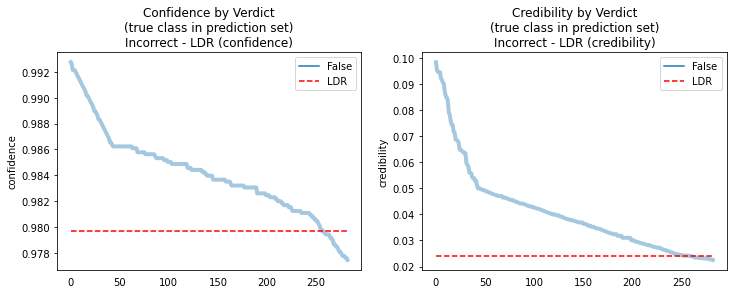

In [ ]:
a = experiment_logistic_10x_downsampl.loc[0, 'df']
l = df_pred_logistic_10x_downsampl_ldr

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(a, axs[0], title_suffix='\nAll (confidence)')
plot_credibility_by_verdict(a, axs[1], title_suffix='\nAll (credibility)')
fig.set_figwidth(12)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(l, axs[0], title_suffix='\nLDR (confidence)')
plot_credibility_by_verdict(l, axs[1], title_suffix='\nLDR (credibility)')
fig.set_figwidth(12)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(util.get_incorrect_predictions(a), axs[0], title_suffix='\nIncorrect - All (confidence)')
plot_credibility_by_verdict(util.get_incorrect_predictions(a), axs[1], title_suffix='\nIncorrect - All (credibility)')
fig.set_figwidth(12)

fig, axs = plt.subplots(1,2)
plot_confidence_by_verdict(util.get_incorrect_predictions(l), axs[0], title_suffix='\nIncorrect - LDR (confidence)')
plot_credibility_by_verdict(util.get_incorrect_predictions(l), axs[1], title_suffix='\nIncorrect - LDR (credibility)')
fig.set_figwidth(12)

Ming et al. produced a synthetic dataset tailored toward comparing ML techniques to the traditional Gail Model.

Ming et al.'s data generation procedure is ammenable to experimentation. 

For ease of experimentation, Ming et al.'s procedure was aggregated and parameterized.

For our underlying classifers, we used both model-based and model-free ML techniques. 

The model-based statistical technique we selected was Logistic Regression, which is often considered a baseline method.
[Gao, C., Sun, H., Wang, T. et al. Model-based and Model-free Machine Learning Techniques for Diagnostic Prediction and Classification of Clinical Outcomes in Parkinson’s Disease. Sci Rep 8, 7129 (2018). https://doi.org/10.1038/s41598-018-24783-4]

The model-free ML technique we selected include RF, ADA, and KNN.

These underlying classifiers were wrapped in Inductive Conformal Predictors utilizing a general purpose nonconformity measure known as Inverse Probability.





[Vanwinckelen, Gitte (2 October 2019). On Estimating Model Accuracy with Repeated Cross-Validation. lirias.kuleuven. pp. 39–44. ISBN 9789461970442.]

In [ ]:
Update on Practicum 

Problem Statement in our own Words: 

Machine Learning could be used in the medical field to inform the decisions of physicians and clinicians; 
but most models are evaluated with global metrics that measure the model's performance on the dataset. 
Medical decisions are made on individuals and not groups; which constrains the value of these metrics 
on ML models used in the medical field. Our goal has been to find how conformal prediction tools could
be used to address this issue. 

Most important Reference Papers: 

The paper that serves as the background for our project is Vazquez J, Facelli [1]. It is a review of 
14 papers that used conformal prediction to address our problem statement. It found that these studies 
were performed in isolation and did not provide any comparisons between approaches. A comparison of 
different approaches and algorithms is a goal that we gleaned from this paper. 

To be able to make those comparisons we would need a dataset that we could experiment with. Ming[ 2] is 
a paper that looks at the performance of several machine learning models compared to performance the of 
other statistical approaches for predicting the risk for breast cancer. BCRAT and BOADICEA being the 
methods that the machine learning models are compared against. In this paper the author creates synthetic 
data, as well as datasets compiled by other researchers. The synthetic datasets were advantages for our 
project as it did not contain any PHI that we would have to take steps to protect which would slow our 
progress.  

Finally, we wanted to use tools that were already developed and that preformed the conformal statistics 
for us. However [3] is a paper the reviews a software package called Orange Conformal Prediction. This 
package has both a GUI interface and scripting in the python language. This paper reviews the theory 
behind the package but also has examples of usage and performance. This paper was primarily used for 
helping develop our code and learning how to use the Orange Conformal Prediction software. 

Progress: 

Our first action item after getting introduced and organized was to use the git repository from [2] to 
produce the synthetic datasets that we would use in learning Orange Conformal Prediction package and 
comparing different conformal prediction algorithms. The repository was not well organized, commented, 
or version controlled. We had to troubleshoot our way through getting these R scripts to produce our 
datasets while learning what features and data types would be in them.  

Our next objective was to start scripting and using the Orange Conformal Prediction package. Orange 
stores tables in a unique fashion where the target feature is identified, features are labeled with 
datatype, as well as other attributes. We experimented with several built in Machine Learning models 
in the package along with different conformal classifiers and conformal prediction metrics. We found 
the package had around nine different metrics for conformal prediction. We decided that providing 
some global metrics would still be useful and to focus on confidence, credibility, and a multiple 
criterion measure as metrics that address our problem statement. To a clinician looking at a 
prediction of high/low breast cancer risk for an individual patient, the most informative attributes
of the corresponding conformal prediction are credibility and confidence. In this case, credibility 
is what proportion of the time the prediction is expected to be true, and confidence is what 
proportion of the time the opposite of the prediction is not expected to be true. A key aspect of 
making this information useful in clinical practice is finding an intuitive means to present these 
measures of uncertainty with the individual-patient prediction. What defines intuitive is the 
ability of the visual representation to provide the clinician with a sense of how certain they 
are that the prediction of either high or low risk is correct without any explicit explanation 
of how different combinations of a prediction’s credibility and confidence should be interpreted. 

Another crucial decision we made is the method used to estimate the risk-factor distribution of 
the dataset—the basis of the nonconformance measure. The software comes with three methods that 
we could choose from; inductive, transductive, and cross-validation. The transductive method 
recalculates the nonconformance metrics of all predictions upon every prediction while the 
inductive method uses static nonconformance metrics created from a calibration set of the data. 
The cross-validation approach uses several calibration data sets to make the calculations; a mixed 
approach between the two. We assessed that the transductive method is computationally expensive and 
would be untimely, making it impractical for clinical practice. Medical datasets are both large and 
ever-changing. Because medical data is essentially a living dataset where rare events may be added 
to the data at any time, the computation required to regenerate a given means of making predictions 
is crucial. Therefore, we concluded that we would only use the inductive and cross-validation methods. 

Direction 

We want to produce a table comparing the different machine learning models against several different 
conformal prediction metrics. We would also like to create a table that randomly selects a single 
instance of each class from the target feature and shows the credibility and confidence score for 
those instances. We also want to see if we could use those tables to produce some sort of graph that 
intuitively conveys this information to a clinician or anyone trying to make sense of the utility of 
a model for a given instance or individual. If time permits, we want to use some of the code and tools 
we develop to work on a publicly available dataset for a classification problem that is multi-class to 
further our understanding and continue to develop our code and tools. 

Citations:  

Sorted by appearance 

[1] Vazquez J, Facelli JC. Conformal Prediction in Clinical Medical Sciences. Journal of Healthcare Informatics Research 2022 doi: 10.1007/s41666-021-00113-8[published Online First: Epub Date]|. 

[2] Ming C, Viassolo V, Probst-Hensch N, Chappuis PO, Dinov ID, Katapodi MC. Machine learning techniques for personalized breast cancer risk prediction: comparison with the BCRAT and BOADICEA models. Breast Cancer Research 2019;21(1):75 doi: 10.1186/s13058-019-1158-4[published Online First: Epub Date]|. 

[3] Hočevar, T., Zupan, B., & Stålring, J. (2021). Conformal Prediction with Orange. Journal of Statistical Software, 98(7), 1–22. https://doi.org/10.18637/jss.v098.i07 

-----